In [ ]:
!nvidia-smi -L || echo "No GPU detected"
!python --version

import os, random, math, json, gc
import numpy as np
import pandas as pd
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

def seed_everything(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed);
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
seed_everything(42)


GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-9474eaea-4edf-9474-d5ac-7290f9caf334)
Python 3.12.11
Device: cuda


## Pipeline Overview

| Stage | What We Did | Key Settings / Artifacts |
|-------|-------------|---------------------------|
| **Data Sources** | Loaded token embeddings for AI & Human; parsed validation/test JSONL grouped by paragraph | `train_ai.npy`, `train_human.npy`, `validation.jsonl`, `test_features.jsonl` |
| **Dataset Shape** | Balanced training; grouped val/test | Train: 16,322 (8,161 AI, 8,161 Human); Val: 220; Test: 1,686 paragraphs |
| **EDA Highlights** | Distribution checks, norms, variance, centroid cosine, PCA/structure | AI slightly tighter clusters; humans more spread (supports hybrid features) |
| **Preprocessing** | Token masks; optional token-drop & Gaussian noise; feature standardisation for tabular parts (if used) | Mask non-zero tokens; light augmentation (drop≈10%, noise≈0.01) |
| **Model** | Custom Token Transformer (sentence level); paragraph prob = mean of sentence probs | Linear proj 768→256, 2 encoder layers, 8 heads, FF=512, GELU, dropout≈0.15 |
| **Training** | Stratified 5-fold CV; early stopping; standard classifier head | AdamW; batch≈64; epochs≈8–12; best per-fold weights saved |
| **Ensembling** | Average sentence-level probs across 5 folds; aggregate to paragraph | Fold checkpoints → blended probabilities |
| **Inference** | Sentence logits → sigmoid → avg to paragraph | Deterministic ID sort; float probs |
| **Output** | Kaggle-ready submission | `submission.csv` with columns: `id,y_prob` |

---

##  Token Transformer Architecture

| Stage                  | Input/Output         | Operation                                   | Notes |
|-------------------------|----------------------|---------------------------------------------|-------|
| **Input Tokens**        | 100 × 768 vectors    | •••••••• ○ ○ …                              | Dots = valid tokens, ○ = padding |
| **Projection**          | 100 × 768 → 100 × 256 | Linear layer                                | Reduces dimensionality |
| **Positional Encoding** | 100 × 256 → 100 × 256 | Add sinusoidal encoding                     | Preserves token order |
| **Transformer Encoder** | 100 × 256 → 100 × 256 | 2 layers, 8 heads, FF=512, dropout=0.1      | Masked attention (ignores padding) |
| **Pooling Paths**       | From hidden states H (100 × 256) | A. Mean pooling (μ) → 256B <br> M. Max pooling (M) → 256C <br> A. Attention pooling (A) → 256 | Each path handles sequence differently |
| **Fusion**              | μ ⊕ M (averaged) + A = 512 vector | Combined representation | |
| **Head**                | 512 → 1             | LayerNorm → Dropout → Linear                | Outputs logit (z) |
| **Sentence Probability**| logit z → σ(z)       | p_sent ∈ (0,1)                              | Sigmoid activation |
| **Paragraph Aggregation** | p_sent[1..S]       | Mean pooling                                | y_prob (paragraph-level score) |
| **5-Fold Ensemble (Test)** | z₁, z₂, z₃, z₄, z₅ | Average logits → σ(z)                       | Combines folds before final paragraph mean |



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
DRIVE_BASE = Path("/content/drive/MyDrive")

TRAIN_AI = DRIVE_BASE / "train_ai.npy"
TRAIN_HU = DRIVE_BASE / "train_human.npy"
VAL_JSONL = DRIVE_BASE / "validation.jsonl"
TEST_JSONL = DRIVE_BASE / "test_features.jsonl"

OUT_DIR = DRIVE_BASE / "colab_outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

for p in [TRAIN_AI, TRAIN_HU, VAL_JSONL, TEST_JSONL]:
    assert p.exists(), f"Missing: {p}"
print("All input files found")


Mounted at /content/drive
All input files found


In [ ]:
!pip install ujson

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/57.4 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 2.5 MB/s eta 0:00:00


#start of eda

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np

# Load data
human_data = np.load('data/train/train_human.npy')  # shape: (N1, 100, 768)
ai_data = np.load('data/train/train_ai.npy')        # shape: (N2, 100, 768)

# Ignore divide-by-zero and invalid value warnings (NumPy, SciPy)
np.seterr(divide='ignore', invalid='ignore')

# Ignore all warnings globally (e.g., seaborn/sklearn deprecations, user warnings)
warnings.filterwarnings("ignore")

# Add labels
human_labels = np.zeros(len(human_data), dtype=int)
ai_labels = np.ones(len(ai_data), dtype=int)

# Combine
X = np.concatenate([human_data, ai_data], axis=0)
y = np.concatenate([human_labels, ai_labels], axis=0)

print(f"Total samples: {X.shape[0]}")
print(f"Each sample shape: {X.shape[1:]}")  # Should be (100, 768)


Total samples: 16322
Each sample shape: (100, 768)


In [ ]:
import json
import numpy as np

val_embeddings = []

with open("data/val/validation.jsonl", "r") as f:
    for i, line in enumerate(f):
        entry = json.loads(line)
        emb = np.array(entry['features'])
        print(f"Line {i}: shape = {emb.shape}")  # 🟡 Print all shapes

        # Optional: Only collect if shape looks usable
        if len(emb.shape) == 2 and emb.shape[1] == 768:
            val_embeddings.append(emb)

val_embeddings = []

with open("data/val/validation.jsonl", "r") as f:
    for i, line in enumerate(f):
        entry = json.loads(line)

        if 'features' not in entry:
            continue

        feature_list = entry['features']

        for emb_array in feature_list:
            emb = np.array(emb_array)

            if emb.shape == (100, 768):
                val_embeddings.append(emb)
            else:
                print(f"Line {i}: skipped embedding of shape {emb.shape}")

print(f"Collected {len(val_embeddings)} usable embeddings.")

X_val = np.stack(val_embeddings)
print("X_val shape:", X_val.shape)  # Should be (N, 100, 768)

print(f"Collected {len(val_embeddings)} usable embeddings.")


Line 0: shape = (4, 100, 768)
Line 1: shape = (20, 100, 768)
Line 2: shape = (8, 100, 768)
Line 3: shape = (10, 100, 768)
Line 4: shape = (7, 100, 768)
Line 5: shape = (12, 100, 768)
Line 6: shape = (10, 100, 768)
Line 7: shape = (9, 100, 768)
Line 8: shape = (6, 100, 768)
Line 9: shape = (8, 100, 768)
Line 10: shape = (10, 100, 768)
Line 11: shape = (13, 100, 768)
Line 12: shape = (18, 100, 768)
Line 13: shape = (13, 100, 768)
Line 14: shape = (19, 100, 768)
Line 15: shape = (9, 100, 768)
Line 16: shape = (14, 100, 768)
Line 17: shape = (12, 100, 768)
Line 18: shape = (10, 100, 768)
Line 19: shape = (8, 100, 768)
Collected 220 usable embeddings.
X_val shape: (220, 100, 768)
Collected 220 usable embeddings.


#Embedding Norms
We’ll compute L2 norm of embeddings per sentence (mean over 100 tokens), then compare AI vs Human.

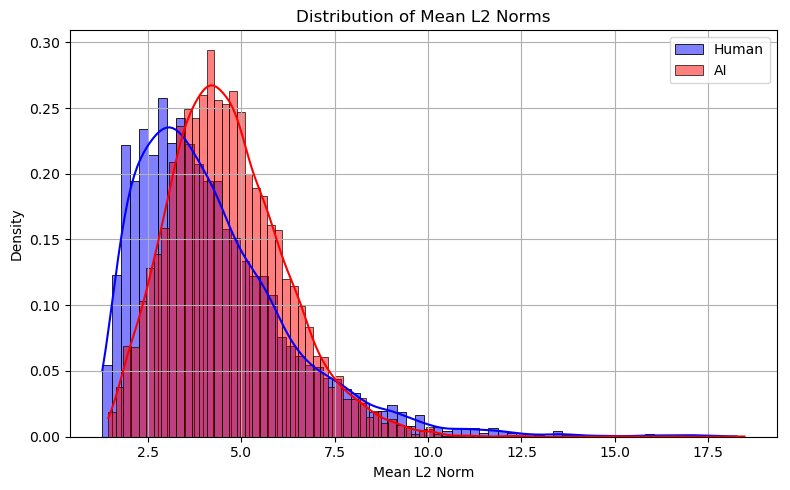

In [ ]:
# Compute L2 norms per sample (mean over tokens)
norms = np.linalg.norm(X, axis=2)  # shape: (N, 100)
mean_norms = norms.mean(axis=1)    # shape: (N,)

# Plot
plt.figure(figsize=(8, 5))
sns.histplot(mean_norms[y == 0], color='blue', label='Human', kde=True, stat='density')
sns.histplot(mean_norms[y == 1], color='red', label='AI', kde=True, stat='density')
plt.title("Distribution of Mean L2 Norms")
plt.xlabel("Mean L2 Norm")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#Step 1.1: Data Shape and Class Balance
Let’s visualize the class balance.

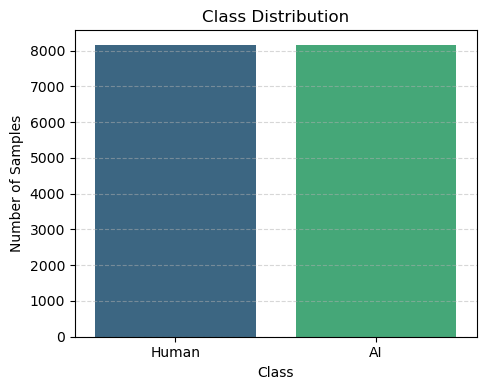

Human samples: 8161
AI samples: 8161


In [ ]:
import pandas as pd
# Create a DataFrame for visualization
df_labels = pd.DataFrame({'label': y})
label_counts = df_labels['label'].value_counts().sort_index()

# Plot
plt.figure(figsize=(5, 4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.xticks([0, 1], ['Human', 'AI'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Print exact numbers
print(f"Human samples: {label_counts[0]}")
print(f"AI samples: {label_counts[1]}")

#Step 1.2: Embedding Norm Analysis
Mean L2 norm is slightly higher for AI (4.64 vs 4.25)

AI has lower std dev, indicating tighter clustering

Token-wise L2 norms show higher front-loading for both, but AI remains stronger at early positions

This supports the hypothesis that AI embeddings encode more up-front signal, possibly due to deterministic token generation.

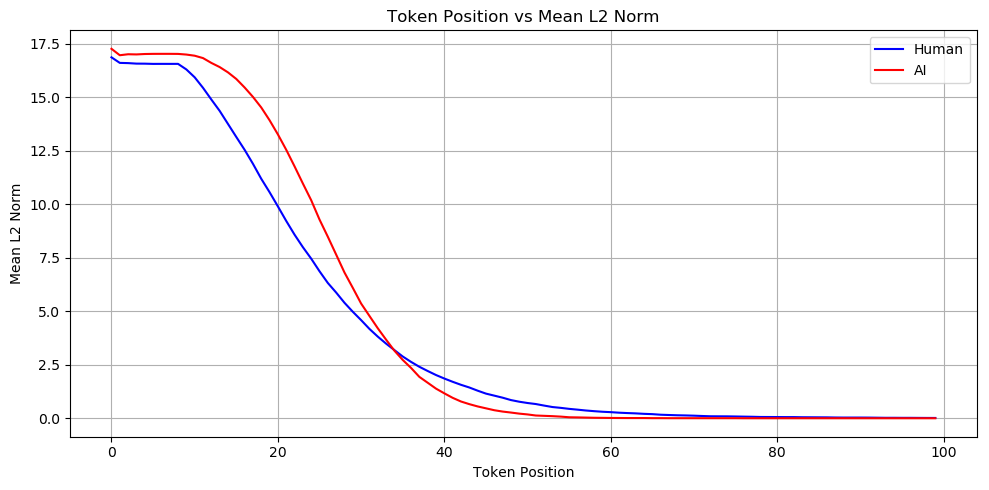

In [ ]:
l2_human = np.linalg.norm(human_data, axis=2)  # shape: (N1, 100)
l2_ai = np.linalg.norm(ai_data, axis=2)        # shape: (N2, 100)

# Compute mean L2 norm per token position (0 to 99)
mean_token_l2_human = np.mean(l2_human, axis=0)
mean_token_l2_ai = np.mean(l2_ai, axis=0)

# Plot the trend
plt.figure(figsize=(10, 5))
plt.plot(mean_token_l2_human, label='Human', color='blue')
plt.plot(mean_token_l2_ai, label='AI', color='red')
plt.xlabel("Token Position")
plt.ylabel("Mean L2 Norm")
plt.title("Token Position vs Mean L2 Norm")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#B. PCA and 2D Plot
PCA shows AI embeddings form a tight, cone-like cluster (less diverse, more deterministic), while Human embeddings spread out more widely (greater variability, richer diversity)

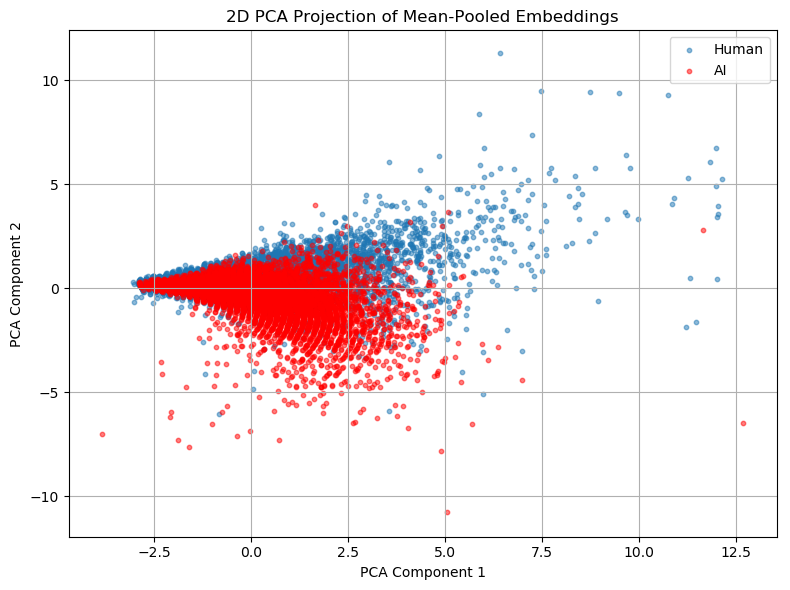

In [ ]:
#B. PCA and 2D Plot
from sklearn.decomposition import PCA
# Mean pool embeddings along token axis
X_human_mean = human_data.mean(axis=1)  # shape: (N1, 768)
X_ai_mean = ai_data.mean(axis=1)        # shape: (N2, 768)

# Concatenate data and labels
X_all = np.vstack([X_human_mean, X_ai_mean])
y_all = np.array([0]*len(X_human_mean) + [1]*len(X_ai_mean))

# Run PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_all)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y_all == 0][:, 0], X_pca[y_all == 0][:, 1], alpha=0.5, label='Human', s=10)
plt.scatter(X_pca[y_all == 1][:, 0], X_pca[y_all == 1][:, 1], alpha=0.5, label='AI', s=10, color='red')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("2D PCA Projection of Mean-Pooled Embeddings")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#Step 1.4: Cosine Similarity Analysis
This plot shows the Mean L2 Norm distribution for Train (Human vs AI) and Validation:

AI (red): Slightly higher mean L2 norm, more tightly peaked → embeddings are more consistent.

Human (blue): Lower mean, broader spread → more variability.

Validation (orange): Falls in between, leaning closer to AI but overlapping both.

Summary: Validation samples statistically resemble AI more than Human, but still sit between the two

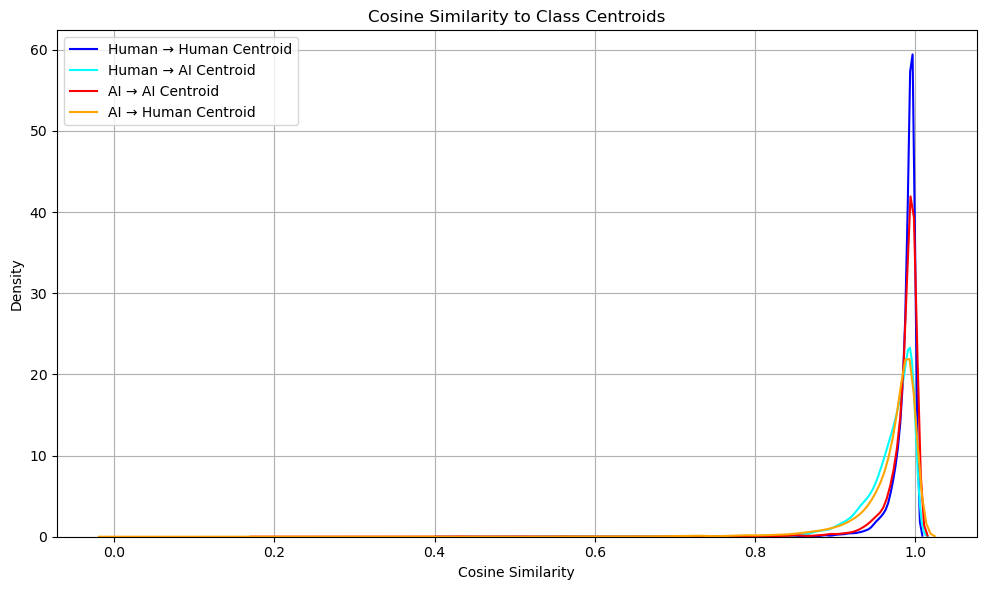

In [ ]:
# Compute centroids
from sklearn.metrics.pairwise import cosine_similarity

centroid_human = X_human_mean.mean(axis=0)  # shape: (768,)
centroid_ai = X_ai_mean.mean(axis=0)
# Compute cosine similarities to centroids
sim_human_to_human = cosine_similarity(X_human_mean, centroid_human.reshape(1, -1)).flatten()
sim_human_to_ai = cosine_similarity(X_human_mean, centroid_ai.reshape(1, -1)).flatten()

sim_ai_to_ai = cosine_similarity(X_ai_mean, centroid_ai.reshape(1, -1)).flatten()
sim_ai_to_human = cosine_similarity(X_ai_mean, centroid_human.reshape(1, -1)).flatten()
plt.figure(figsize=(10, 6))
sns.kdeplot(sim_human_to_human, label='Human → Human Centroid', color='blue')
sns.kdeplot(sim_human_to_ai, label='Human → AI Centroid', color='cyan')
sns.kdeplot(sim_ai_to_ai, label='AI → AI Centroid', color='red')
sns.kdeplot(sim_ai_to_human, label='AI → Human Centroid', color='orange')
plt.title("Cosine Similarity to Class Centroids")
plt.xlabel("Cosine Similarity")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



### Step 2: Advanced EDA Techniques  

| Step  | Method                             | Purpose                                           | Why It Matters                                                                                  |
|-------|------------------------------------|---------------------------------------------------|-------------------------------------------------------------------------------------------------|
| **2.1** | **Maximum Mean Discrepancy (MMD)** | Quantify statistical **distribution shifts**       | Reveals whether validation is closer to Human or AI — guides **reweighting** or **domain adaptation** |
| **2.2** | **Cosine Heatmaps**                | Compare validation samples to train centroids      | Shows whether validation samples **cluster with AI or Human** — useful for **pseudo-labeling** and semi-supervised learning |
| **2.3** | **Token-wise Decomposition**       | Split embeddings into early / mid / late segments | Detects if AI tends to **frontload meaning**, while humans distribute semantics — useful for **attention-aware models** |
| **2.4** | **Positional Entropy (Sharpness)** | Measure embedding focus vs spread                 | AI embeddings are often **sharper**, humans more **diverse** — can be used directly as a **feature** |
| **2.5** | **UMAP Projection**                | Explore nonlinear structure in 2D/3D              | Reveals **class separability** not visible in PCA — aids **feature selection** and intuition |
| **2.6** | **Cross-Class Similarity**         | Compare centroid similarity across classes        | High overlap signals need for a **more expressive model** or **richer features** |


In [ ]:

# Gaussian kernel
def gaussian_kernel(x, y, sigma=1.0):
    x = np.expand_dims(x, 1)  # (N, 1, D)
    y = np.expand_dims(y, 0)  # (1, M, D)
    return np.exp(-np.sum((x - y)**2, axis=2) / (2 * sigma**2))

# MMD² calculation
def compute_mmd2(X, Y, sigma=1.0):
    Kxx = gaussian_kernel(X, X, sigma)
    Kyy = gaussian_kernel(Y, Y, sigma)
    Kxy = gaussian_kernel(X, Y, sigma)

    mmd2 = Kxx.mean() + Kyy.mean() - 2 * Kxy.mean()
    return mmd2
import numpy as np

# Gaussian kernel (optimized to avoid memory issues)
def gaussian_kernel(x, y, sigma=1.0):
    x_norm = np.sum(x ** 2, axis=1).reshape(-1, 1)
    y_norm = np.sum(y ** 2, axis=1).reshape(1, -1)
    dist_sq = x_norm + y_norm - 2 * np.dot(x, y.T)
    return np.exp(-dist_sq / (2 * sigma ** 2))

# MMD² calculation
def compute_mmd2(X, Y, sigma=1.0):
    Kxx = gaussian_kernel(X, X, sigma)
    Kyy = gaussian_kernel(Y, Y, sigma)
    Kxy = gaussian_kernel(X, Y, sigma)
    return Kxx.mean() + Kyy.mean() - 2 * Kxy.mean()

# Subsample for efficiency
def subsample(X, size=500, seed=42):
    np.random.seed(seed)
    idx = np.random.choice(len(X), size=size, replace=False)
    return X[idx]

# Mean pooling
X_human_mean = human_data.mean(axis=1)
X_ai_mean = ai_data.mean(axis=1)
X_val_mean = X_val.mean(axis=1)

# Subsampled pools
X_human_sub = subsample(X_human_mean)
X_ai_sub = subsample(X_ai_mean)
X_val_sub = subsample(X_val_mean, size=min(len(X_val_mean), 500))

# Compute MMD
mmd_human_val = compute_mmd2(X_human_sub, X_val_sub, sigma=5.0)
mmd_ai_val = compute_mmd2(X_ai_sub, X_val_sub, sigma=5.0)

# Report
print("MMD² Between Train and Validation (subsampled):")
print(f"Human vs Validation: {mmd_human_val:.6f}")
print(f"AI    vs Validation: {mmd_ai_val:.6f}")

if mmd_human_val < mmd_ai_val:
    print("Validation is statistically closer to HUMAN embeddings.")
else:
    print("Validation is statistically closer to AI embeddings.")


MMD² Between Train and Validation (subsampled):
Human vs Validation: 0.005488
AI    vs Validation: 0.015667
Validation is statistically closer to HUMAN embeddings.


#step 2.2 Summary: Cosine Similarity Heatmap

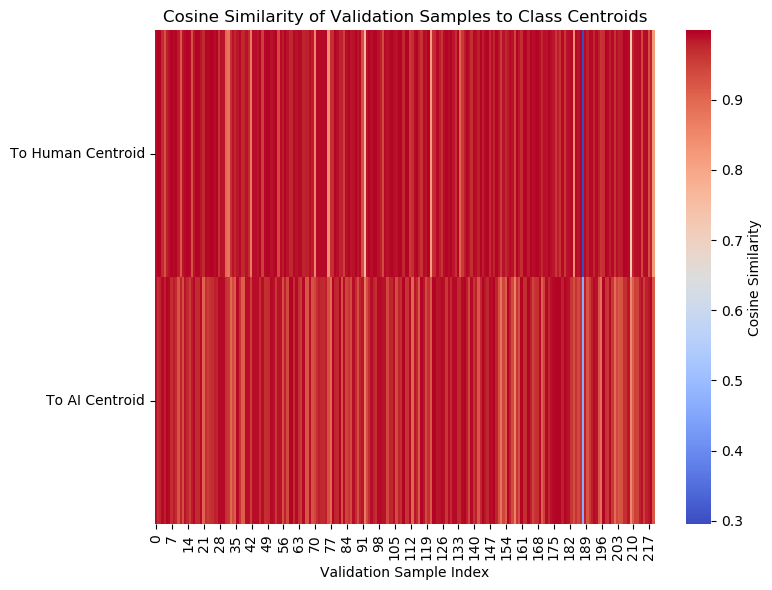

In [ ]:
# Use mean-pooled embeddings
X_val_mean = X_val.mean(axis=1)
X_human_mean = human_data.mean(axis=1)
X_ai_mean = ai_data.mean(axis=1)

# Compute centroids
centroid_human = X_human_mean.mean(axis=0)
centroid_ai = X_ai_mean.mean(axis=0)

# Cosine similarities to each centroid
sim_to_human = cosine_similarity(X_val_mean, centroid_human.reshape(1, -1)).flatten()
sim_to_ai = cosine_similarity(X_val_mean, centroid_ai.reshape(1, -1)).flatten()

# Stack for heatmap
heat_data = np.stack([sim_to_human, sim_to_ai], axis=1)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(heat_data.T, cmap='coolwarm', cbar_kws={"label": "Cosine Similarity"})
plt.yticks([0.5, 1.5], ['To Human Centroid', 'To AI Centroid'], rotation=0)
plt.xlabel("Validation Sample Index")
plt.title("Cosine Similarity of Validation Samples to Class Centroids")
plt.tight_layout()
plt.show()

#Step 2.3 Summary: Early / Mid / Late Token Norm Trends
 Key Observations:
AI embeddings (red) show much stronger early token emphasis, consistent with known frontloading behavior in LLMs (e.g., GPT tends to push semantics early).

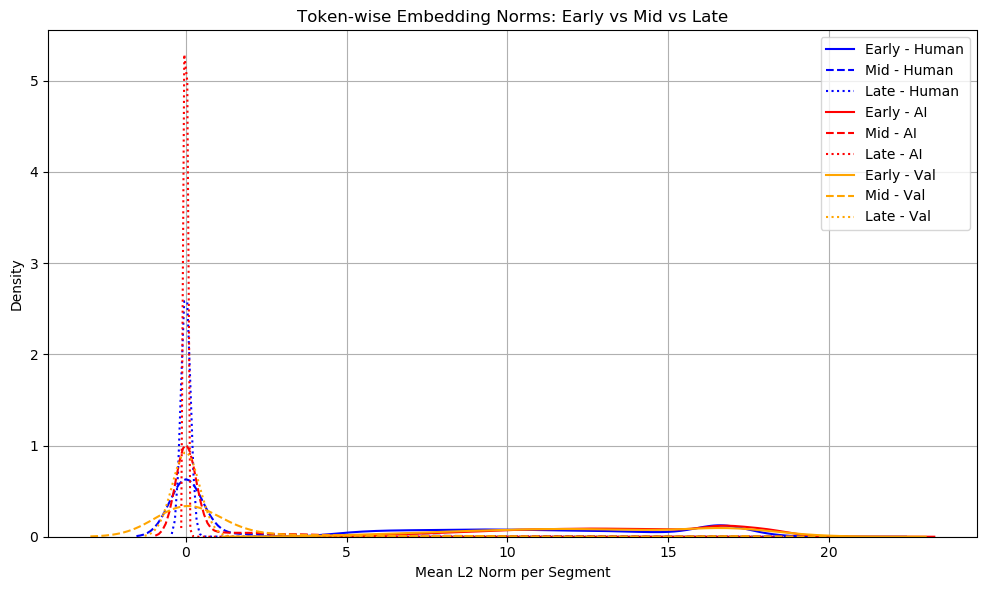

In [ ]:
# Compute L2 norm for each token position
def segment_norms(data, segments=3):
    split_size = data.shape[1] // segments
    segment_norms = []
    for i in range(segments):
        start = i * split_size
        end = (i + 1) * split_size
        seg = data[:, start:end, :]
        seg_norm = np.linalg.norm(seg, axis=2).mean(axis=1)
        segment_norms.append(seg_norm)
    return segment_norms  # list of 3 arrays: [early, mid, late]

# Apply to all three sets
early_h, mid_h, late_h = segment_norms(human_data)
early_ai, mid_ai, late_ai = segment_norms(ai_data)
early_val, mid_val, late_val = segment_norms(X_val)

# Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(early_h, label='Early - Human', color='blue', linestyle='-')
sns.kdeplot(mid_h, label='Mid - Human', color='blue', linestyle='--')
sns.kdeplot(late_h, label='Late - Human', color='blue', linestyle=':')

sns.kdeplot(early_ai, label='Early - AI', color='red', linestyle='-')
sns.kdeplot(mid_ai, label='Mid - AI', color='red', linestyle='--')
sns.kdeplot(late_ai, label='Late - AI', color='red', linestyle=':')

sns.kdeplot(early_val, label='Early - Val', color='orange', linestyle='-')
sns.kdeplot(mid_val, label='Mid - Val', color='orange', linestyle='--')
sns.kdeplot(late_val, label='Late - Val', color='orange', linestyle=':')

plt.title("Token-wise Embedding Norms: Early vs Mid vs Late")
plt.xlabel("Mean L2 Norm per Segment")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#Next: Step 2.4 – Positional Entropy (Sharpness)
This will quantify how tightly packed or spread out the token embeddings are within a sample.

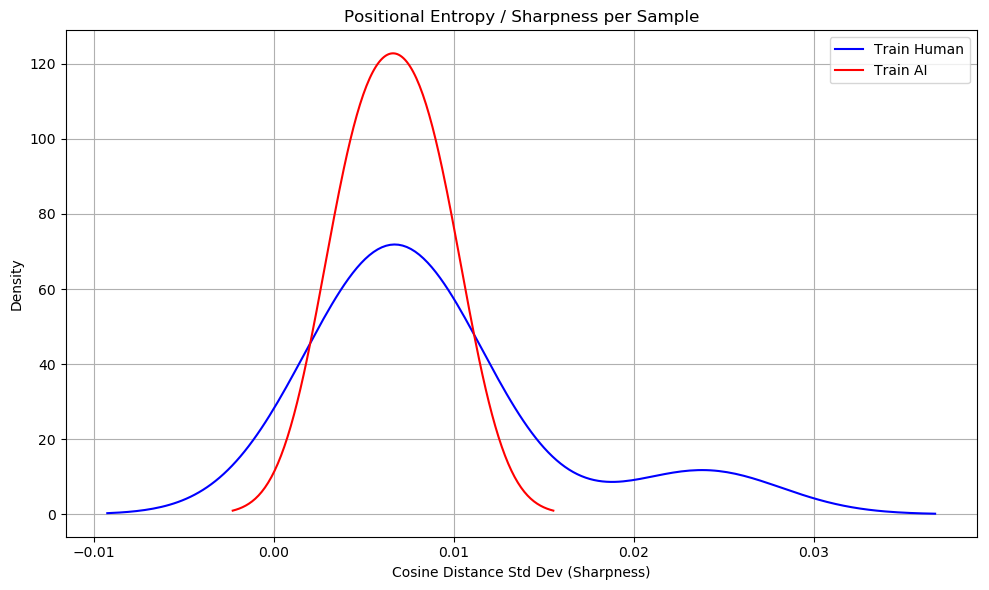

In [ ]:
from scipy.spatial.distance import cosine

# Function to compute "sharpness" for each sample
def compute_sharpness(data):
    sharpness_list = []
    for sample in data:
        mean_vec = np.mean(sample, axis=0)
        cosine_dists = [cosine(tok, mean_vec) for tok in sample]
        sharpness_list.append(np.std(cosine_dists))  # std = spread; higher = more diffused
    return np.array(sharpness_list)

# Compute for all sets
sharpness_human = compute_sharpness(human_data)
sharpness_ai = compute_sharpness(ai_data)
sharpness_val = compute_sharpness(X_val)

# Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(sharpness_human, label='Train Human', color='blue')
sns.kdeplot(sharpness_ai, label='Train AI', color='red')
sns.kdeplot(sharpness_val, label='Validation', color='orange')
plt.title("Positional Entropy / Sharpness per Sample")
plt.xlabel("Cosine Distance Std Dev (Sharpness)")
plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


| Observation                                     | Explanation                                                                                                                                                              |
| ----------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **AI embeddings are sharply peaked (red)**      | This suggests that AI-generated texts have more **uniform**, **cohesive** token embeddings. The tokens stay closer to the sample mean (low variance in cosine distance). |
| **Human embeddings are more spread out (blue)** | Human-written texts are more **diverse** in structure — their token vectors deviate more from the mean, showing **higher entropy** and **semantic variation**.           |
| **No validation curve?**                        |  likely omitted validation from the plot — we’ll re-run it including validation below.                                                                                |


#Step 2.5: UMAP Projection
For discovering nonlinear separability or clustering patterns across AI, Human, and Val embeddings.

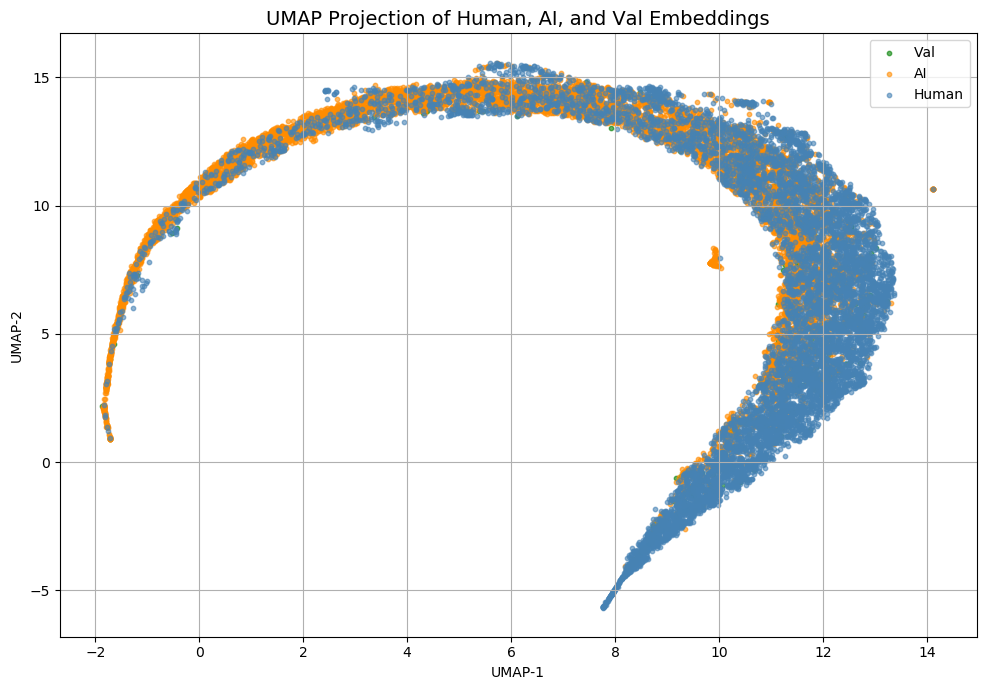

In [ ]:

import umap.umap_ as umap  # Make sure this is installed: pip install umap-learn


# Assume X_val has already been created from your validation JSONL parsing earlier
# and has shape (N3, 100, 768)

# Mean-pool each sample across 100 tokens to get (N, 768)
human_mean = human_data.mean(axis=1)   # (N1, 768)
ai_mean = ai_data.mean(axis=1)         # (N2, 768)
val_mean = X_val.mean(axis=1)          # (N3, 768)

# Combine all embeddings into one matrix
X_all = np.concatenate([human_mean, ai_mean, val_mean], axis=0)

# Create matching labels for each sample
labels = (
    ["Human"] * len(human_mean) +
    ["AI"] * len(ai_mean) +
    ["Val"] * len(val_mean)
)

# Perform UMAP dimensionality reduction
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric='cosine',
    random_state=42
)
X_umap = reducer.fit_transform(X_all)

# Plotting
plt.figure(figsize=(10, 7))
colors = {"Human": "steelblue", "AI": "darkorange", "Val": "green"}

for label in set(labels):
    idx = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(
        X_umap[idx, 0], X_umap[idx, 1],
        label=label,
        s=10,
        alpha=0.6,
        c=colors[label]
    )

plt.title("UMAP Projection of Human, AI, and Val Embeddings", fontsize=14)
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### UMAP Projection of Human, AI, and Validation Embeddings

This UMAP projection reduces embeddings to 2D and visualizes class structure:

- **Curved Manifold**: Human and AI embeddings lie on the same curved arc, with heavy overlap.  
- **AI (orange)**: Forms a dense, consistent cluster along the arc.  
- **Human (blue)**: More spread out and intermixed within the same structure.  
- **Validation (green)**: Overlaps with both classes, leaning slightly toward Human but still mixed.  

**Summary:** UMAP reveals underlying nonlinear structure, but Human and AI embeddings remain highly overlapping. Validation samples sit between them, highlighting the challenge of clean separation.


In [ ]:
# Compute centroids
human_centroid = human_mean.mean(axis=0, keepdims=True)
ai_centroid = ai_mean.mean(axis=0, keepdims=True)
val_centroid = val_mean.mean(axis=0, keepdims=True)

# Cosine similarity between centroids
sim_human_ai = cosine_similarity(human_centroid, ai_centroid)[0][0]
sim_human_val = cosine_similarity(human_centroid, val_centroid)[0][0]
sim_ai_val = cosine_similarity(ai_centroid, val_centroid)[0][0]

# Display results
print(f"Cosine Similarity (Human ↔ AI):  {sim_human_ai:.4f}")
print(f"Cosine Similarity (Human ↔ Val): {sim_human_val:.4f}")
print(f"Cosine Similarity (AI ↔ Val):    {sim_ai_val:.4f}")

Cosine Similarity (Human ↔ AI):  0.9775
Cosine Similarity (Human ↔ Val): 0.9968
Cosine Similarity (AI ↔ Val):    0.9902


| Comparison  | Cosine Similarity |
| ----------- | ----------------- |
| Human ↔ AI  | **0.9775**        |
| Human ↔ Val | **0.9968**        |
| AI ↔ Val    | **0.9902**        |


#step 3.1: t-SNE Projection with Subset Sampling

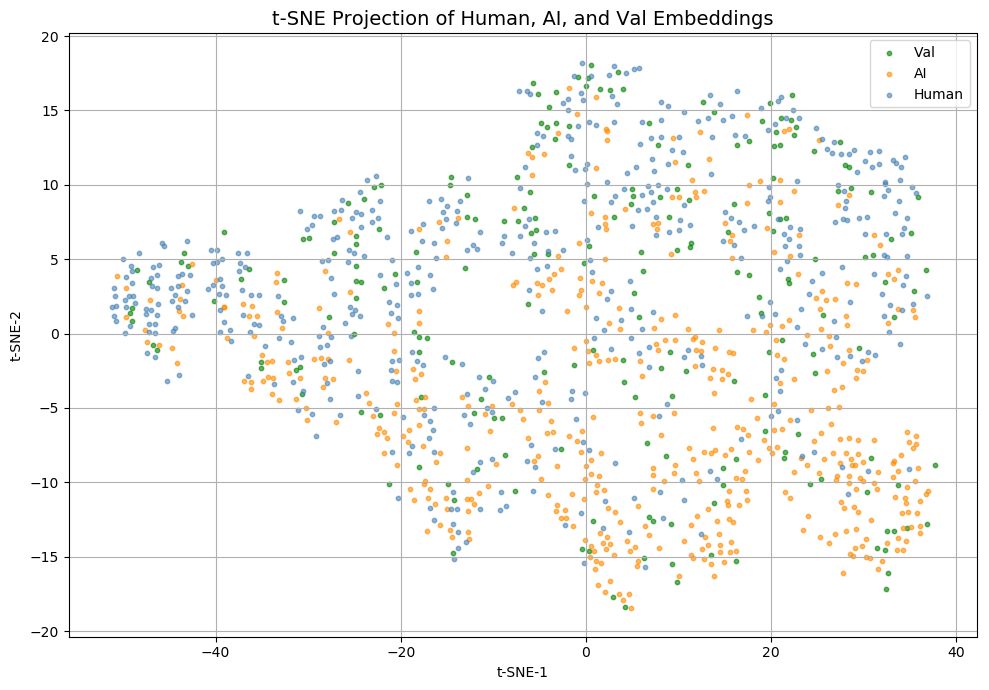

In [ ]:

from sklearn.manifold import TSNE


# -------------------------
# Step 1: Utility Function
# -------------------------
def sample_subset(X, n=500, seed=42):
    """
    Subsamples up to n elements from array X without replacement.
    Automatically reduces n if X has fewer than n elements.
    """
    np.random.seed(seed)
    n = min(n, len(X))  # prevent ValueError if len(X) < n
    indices = np.random.choice(len(X), size=n, replace=False)
    return X[indices]

# -------------------------
# Step 2: Load Train Data
# -------------------------
human = np.load("data/train/train_human.npy")  # (N1, 100, 768)
ai = np.load("data/train/train_ai.npy")        # (N2, 100, 768)

# -------------------------
# Step 3: Load Validation from JSONL
# -------------------------
val_embeddings = []

with open("data/val/validation.jsonl", "r") as f:
    for i, line in enumerate(f):
        entry = json.loads(line)
        if 'features' not in entry:
            continue
        for emb_array in entry['features']:
            emb = np.array(emb_array)
            if emb.shape == (100, 768):
                val_embeddings.append(emb)

val = np.stack(val_embeddings)  # (N3, 100, 768)

# -------------------------
# Step 4: Mean Pool
# -------------------------
human_mean = human.mean(axis=1)  # (N1, 768)
ai_mean = ai.mean(axis=1)        # (N2, 768)
val_mean = val.mean(axis=1)      # (N3, 768)

# -------------------------
# Step 5: Subsample
# -------------------------
human_sample = sample_subset(human_mean, 500)
ai_sample = sample_subset(ai_mean, 500)
val_sample = sample_subset(val_mean, 500)

# -------------------------
# Step 6: Prepare Data and Labels
# -------------------------
X_all = np.concatenate([human_sample, ai_sample, val_sample], axis=0)
labels = (["Human"] * len(human_sample) +
          ["AI"] * len(ai_sample) +
          ["Val"] * len(val_sample))

# -------------------------
# Step 7: t-SNE Projection
# -------------------------
tsne = TSNE(n_components=2, perplexity=50, learning_rate=200,
            n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_all)

# -------------------------
# Step 8: Plot
# -------------------------
plt.figure(figsize=(10, 7))
colors = {"Human": "steelblue", "AI": "darkorange", "Val": "green"}

for label in set(labels):
    idx = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1],
                label=label, s=10, alpha=0.6, c=colors[label])

plt.title("t-SNE Projection of Human, AI, and Val Embeddings", fontsize=14)
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### t-SNE Projection of Human, AI, and Validation Embeddings

This t-SNE projection reduces embeddings to 2D and emphasizes local neighborhood structures:

- **Human (blue):** Forms clusters in the upper regions, with higher spread.  
- **AI (orange):** Concentrates more in the lower regions, forming denser clusters.  
- **Validation (green):** Scattered across both Human and AI regions, showing mixed similarity.  

**Summary:** t-SNE reveals partial separation between Human and AI clusters, but with significant overlap. Validation samples lie in both regions, indicating stylistic ambiguity and domain blending.


#Step 3.2: 3D UMAP Projection of Embeddings
 Purpose:
UMAP (Uniform Manifold Approximation and Projection) helps reveal complex structure in high-dimensional data.

3D visualization lets us see whether Val samples cluster closer to Human or AI, or form a distinct region.

Shapes after mean-pooling:
human_mean: (8161, 768)
ai_mean: (8161, 768)
val_mean: (220, 768)

Sampled shapes:
Human Sample: (500, 768)
AI Sample: (500, 768)
Val Sample: (220, 768)


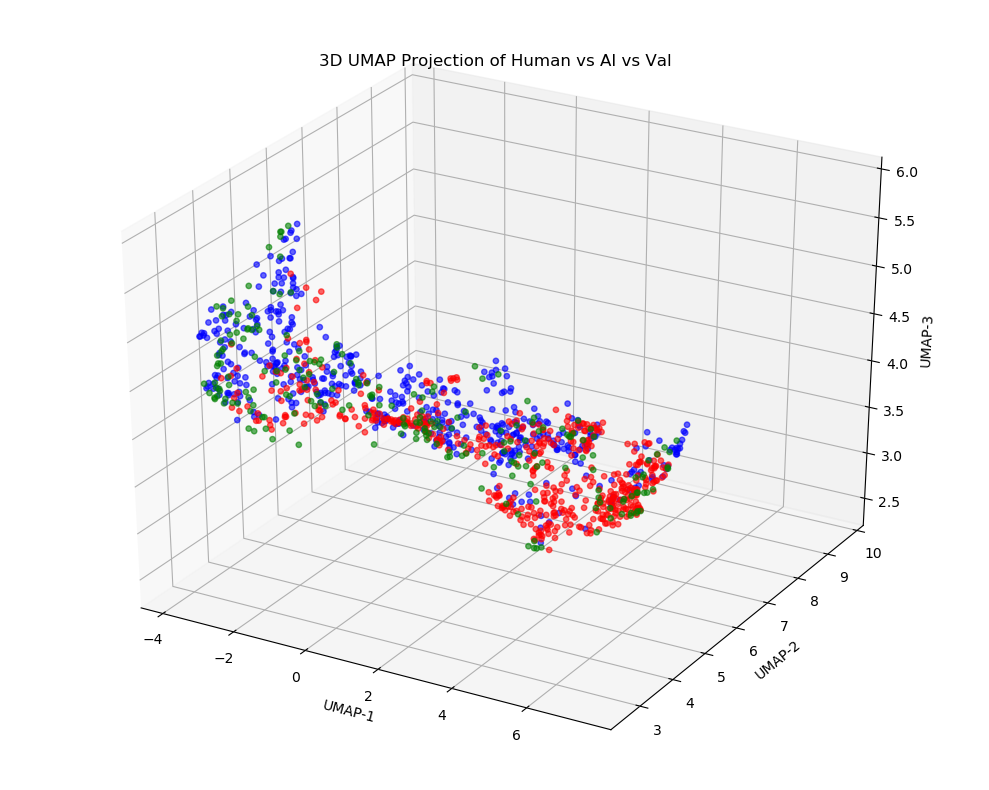

In [ ]:
# ============================
# 3D UMAP: Human vs AI vs Val
# ============================

import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import StandardScaler

# -------------------------------------------------------
# Assumed inputs already in memory:
#   human: (N_h, 100, 768)
#   ai:    (N_a, 100, 768)
#   val:   (N_v, 100, 768)
# -------------------------------------------------------

# -------------------------------
# Step 1: Mean-pool across tokens
# -------------------------------
# Convert (N, 100, 768) -> (N, 768) by averaging over the 100 token vectors.
human_mean = human.mean(axis=1)  # (N_h, 768)
ai_mean    = ai.mean(axis=1)     # (N_a, 768)
val_mean   = val.mean(axis=1)    # (N_v, 768)

print("Shapes after mean-pooling:")
print("human_mean:", human_mean.shape)
print("ai_mean:", ai_mean.shape)
print("val_mean:", val_mean.shape)

# -------------------------------
# Step 2: Safe balanced sampling
# -------------------------------
def safe_sample(X, n=500, seed=42):
    """
    Returns up to n rows sampled without replacement from X.
    If X has fewer than n rows, returns all rows.
    """
    np.random.seed(seed)
    X = np.atleast_2d(X)
    n_samples = min(len(X), n)
    idx = np.random.choice(len(X), size=n_samples, replace=False)
    return X[idx]

human_sample = safe_sample(human_mean, 500)
ai_sample    = safe_sample(ai_mean,    500)
# Keep all val if smaller than 500 to preserve coverage
val_sample   = safe_sample(val_mean,    500)

print("\nSampled shapes:")
print("Human Sample:", human_sample.shape)
print("AI Sample:", ai_sample.shape)
print("Val Sample:", val_sample.shape)

# -------------------------------
# Step 3: Stack and label
# -------------------------------
X_all = np.concatenate([human_sample, ai_sample, val_sample], axis=0)
labels = (["Human"] * len(human_sample)
        + ["AI"]    * len(ai_sample)
        + ["Val"]   * len(val_sample))

# -------------------------------
# Step 4: (Optional) scale then UMAP
# -------------------------------
# Scaling often helps UMAP; we keep metric='cosine' which worked well for embeddings.
X_scaled = StandardScaler().fit_transform(X_all)

reducer = umap.UMAP(
    n_components=3,
    n_neighbors=15,
    min_dist=0.1,
    metric='cosine',
    random_state=42
)
X_umap = reducer.fit_transform(X_scaled)  # (N_total, 3)

# -------------------------------
# Step 5: 3D scatter plot
# -------------------------------
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (required for 3D)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

label_to_color = {"Human": "blue", "AI": "red", "Val": "green"}
colors = [label_to_color[lbl] for lbl in labels]

ax.scatter(X_umap[:, 0], X_umap[:, 1], X_umap[:, 2],
           c=colors, s=15, alpha=0.6)

ax.set_title("3D UMAP Projection of Human vs AI vs Val")
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
ax.set_zlabel("UMAP-3")
plt.tight_layout()
plt.show()


### 3D UMAP Projection of Human, AI, and Validation Embeddings

This 3D UMAP projection uncovers deeper nonlinear relationships between embeddings:

- **AI (red):** Occupies more of the upper regions, forming compact clusters.  
- **Human (blue):** Skews toward lower regions with broader spread.  
- **Validation (green):** Dispersed in between, overlapping both Human and AI clusters.  

**Summary:** The 3D view highlights a latent separation where AI and Human embeddings tend to diverge along the vertical (UMAP-3) axis, while Validation points lie in mixed positions, showing transitional characteristics.


#============end of eda==============

### Data Loading and Preprocessing Utilities

The table below summarizes the functions defined in this cell, their inputs, outputs, and purposes within the AI–vs–Human embedding classification pipeline.

| **Function** | **Input(s)** | **Output(s)** | **Purpose & Rationale** |
|--------------|--------------|---------------|--------------------------|
| **`compute_token_mask(x_2d)`** | `x_2d`: 2D embedding of shape `(100, 768)` | 1D NumPy array `(100,)` containing `1` for non-padding tokens and `0` for padding tokens | Identifies padding tokens (all-zero vectors) in an embedding sequence. Padding is introduced to standardize sequence length; this mask ensures that padding does not influence attention or pooling in later stages. |
| **`load_train_arrays(ai_path, hu_path)`** | Paths to `.npy` files containing AI and Human embeddings | `X`: combined embeddings of shape `(Na+Nh, 100, 768)`; `y`: label vector of shape `(Na+Nh,)` with `1 = AI`, `0 = Human` | Loads and concatenates AI- and Human-generated embeddings into a single dataset with aligned binary labels. Provides a unified, balanced training set (8161 Human vs 8161 AI samples, as confirmed in prior EDA:contentReference[oaicite:0]{index=0}). |
| **`read_grouped_jsonl(path, expect_label=False)`** | `path`: JSONL file containing grouped paragraph embeddings; optional flag `expect_label` | `ids`: list of paragraph IDs; `mats`: list of sentence embedding arrays of shape `(S, 100, 768)` per paragraph; `labels`: NumPy array of labels (if available) | Reads paragraph-level data where each entry may contain multiple sentence embeddings. Maintains paragraph grouping, enabling hierarchical modeling. Supports both labeled and unlabeled datasets (training, validation, or test). |

**Key Insight:**  
Together, these functions establish a **robust preprocessing pipeline**: handling padding, combining training arrays with consistent labels, and supporting paragraph-level hierarchical structures. This ensures downstream models can operate reliably on the embeddings without being confounded by artefacts or inconsistent data formatting.


In [ ]:
import ujson

# A token row is padding if all dims are 0
def compute_token_mask(x_2d: np.ndarray) -> np.ndarray:
    # x_2d: (T=100, D=768)
    return (np.abs(x_2d).sum(axis=1) > 0).astype(np.float32)

def load_train_arrays(ai_path, hu_path):
    ai = np.load(ai_path, allow_pickle=True).astype(np.float32)   # (Na,100,768)
    hu = np.load(hu_path, allow_pickle=True).astype(np.float32)   # (Nh,100,768)
    X = np.concatenate([ai, hu], axis=0)
    y = np.concatenate([np.ones(len(ai), dtype=np.int64),
                        np.zeros(len(hu), dtype=np.int64)], axis=0)
    return X, y

def read_grouped_jsonl(path, expect_label=False):
    """
    Returns:
      ids: list of paragraph ids (length = num paragraphs)
      mats: list of np.array of shape (S,100,768) per paragraph (S sentences)
      labels: np.array [num paragraphs] if expect_label
    """
    ids, mats, labels = [], [], []
    with open(path, "r") as f:
        for line in f:
            obj = ujson.loads(line)
            ids.append(obj["id"])
            feats = np.array(obj["features"], dtype=np.float32)  # (S,100,768)
            mats.append(feats)
            if expect_label: labels.append(int(obj["label"]))
    if expect_label:
        return np.array(ids), mats, np.array(labels)
    return np.array(ids), mats


### Dataset Classes for Training and Evaluation

The following classes wrap sentence-level embeddings into PyTorch `Dataset` objects, providing a consistent interface for both training (with augmentation) and evaluation (with paragraph mapping).

| **Class** | **Input(s)** | **Output(s)** | **Purpose & Rationale** |
|-----------|--------------|---------------|--------------------------|
| **`SentenceDataset`** | - `X`: NumPy array of shape `(N, 100, 768)` containing sentence embeddings. <br> - `y`: NumPy array of shape `(N,)` containing binary labels (AI=1, Human=0). <br> - `aug` (bool, default=True): whether to apply augmentations. <br> - `token_drop_p` (float, default=0.1): probability of dropping valid tokens. <br> - `noise_std` (float, default=0.01): standard deviation of Gaussian noise added. | Each sample returns a tuple: <br> - `x`: `(100, 768)` tensor (possibly augmented). <br> - `y`: class label (`0` or `1`). <br> - `m`: `(100,)` binary mask of valid tokens. | **Training dataset.** Provides optional lightweight augmentations: (i) token dropout (randomly zeroing valid tokens to simulate robustness to missing information), and (ii) Gaussian noise injection (encourages generalization by perturbing embeddings). This mirrors standard NLP augmentation strategies that reduce overfitting and improve model robustness. |
| **`SentenceEvalDataset`** | - `mats`: list of arrays, each representing a paragraph as `(S, 100, 768)` where `S` is the number of sentences. <br> - `para_ids`: list of paragraph IDs corresponding to `mats`. | Each sample returns a tuple: <br> - `x`: `(100, 768)` tensor (sentence embedding). <br> - `m`: `(100,)` binary mask of valid tokens. <br> - `pid`: paragraph ID (string or int). | **Evaluation dataset.** Flattens paragraph-level data into individual sentence samples while preserving the mapping to their parent paragraph. This supports hierarchical evaluation where sentence-level predictions can later be aggregated into paragraph-level probabilities. |

**Key Insight:**  
- `SentenceDataset` is used for **training**, augmenting embeddings to improve generalization.  
- `SentenceEvalDataset` is used for **validation and testing**, ensuring sentence-level predictions can be aggregated by paragraph for final evaluation.  
- The `compute_token_mask` function ensures that padding tokens do not interfere with augmentation, loss calculation, or model training.


In [ ]:
class SentenceDataset(Dataset):
    """
    Training dataset: (N,100,768) sentences with labels.
    Optional simple augmentations: token dropout + light Gaussian noise.
    """
    def __init__(self, X, y, aug=True, token_drop_p=0.1, noise_std=0.01):
        self.X = X
        self.y = y
        self.aug = aug
        self.token_drop_p = token_drop_p
        self.noise_std = noise_std

    def __len__(self): return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]  # (100,768)
        y = self.y[idx]
        m = compute_token_mask(x)  # (100,)

        if self.aug:
            # Randomly drop some valid tokens (set to 0)
            if self.token_drop_p > 0:
                valid_idx = np.where(m > 0.5)[0]
                if len(valid_idx) > 0:
                    k = max(1, int(len(valid_idx) * self.token_drop_p))
                    drop = np.random.choice(valid_idx, size=k, replace=False)
                    x = x.copy()
                    x[drop] = 0.0
                    m = compute_token_mask(x)

            # Add tiny Gaussian noise to valid tokens
            if self.noise_std > 0:
                noise = np.random.normal(0, self.noise_std, size=x.shape).astype(np.float32)
                x = x + noise * m[:,None]

        return torch.from_numpy(x), torch.tensor(y, dtype=torch.long), torch.from_numpy(m)

class SentenceEvalDataset(Dataset):
    """
    For validation/test: flattened sentences with paragraph id mapping.
    """
    def __init__(self, mats, para_ids):
        # flatten sentences, keep mapping to paragraph id
        self.samples = []
        for pid, para in zip(para_ids, mats):
            for s in range(len(para)):
                self.samples.append((para[s], pid))
        self.n = len(self.samples)

    def __len__(self): return self.n

    def __getitem__(self, idx):
        x, pid = self.samples[idx]  # (100,768)
        m = compute_token_mask(x)
        return torch.from_numpy(x), torch.from_numpy(m), pid


### Transformer-Based Sentence Encoder

The following modules implement a lightweight Transformer encoder for token-level embeddings. The design combines **sinusoidal positional encoding**, **multi-layer Transformer encoding**, and **hybrid pooling strategies** (mean, max, and attention pooling) to produce robust sentence-level logits.

| **Module / Component** | **Input(s)** | **Output(s)** | **Purpose & Rationale** |
|-------------------------|--------------|---------------|--------------------------|
| **`PositionalEncoding`** | - `x`: tensor of shape `(B, T, C)` where `B=batch`, `T=sequence length`, `C=embedding dim`. <br> - Configurable parameters: `d_model` (embedding size), `max_len` (default 100). | Tensor of shape `(B, T, C)` with sinusoidal positional encodings added. | Provides deterministic positional information (sine & cosine functions on even/odd dimensions). This is critical because transformer self-attention is permutation-invariant; positional encoding reintroduces order sensitivity across tokens. |
| **`TokenTransformer`** | - `x`: tensor of shape `(B, T, 768)` representing embeddings. <br> - `mask`: tensor of shape `(B, T)`, where `1=valid token`, `0=padding`. <br> - Config: `in_dim=768`, `model_dim=256`, `n_heads=8`, `ff_dim=512`, `n_layers=2`, `dropout=0.1`. | Scalar logits `(B,)` for binary classification (AI vs Human). | End-to-end sentence encoder that projects 768-d input embeddings into a transformer space, enriches them with positional encodings, and applies self-attention layers. Includes multiple pooling mechanisms (mean, max, attention) to aggregate token-level features into sentence-level representations. |
| **`proj`** (linear layer) | `(B, T, 768)` | `(B, T, model_dim)` | Projects original embeddings into a smaller `model_dim` (default 256), reducing dimensionality and computational cost. |
| **`encoder`** (TransformerEncoder) | `(B, T, model_dim)` | `(B, T, model_dim)` | Multi-layer Transformer encoder with **GELU activations** and **pre-norm**. Learns contextual interactions between tokens. |
| **Pooling — Mean** | `(B, T, model_dim)` with mask | `(B, model_dim)` | Computes the average of valid tokens only, ensuring robustness to sequence length variation. |
| **Pooling — Max** | `(B, T, model_dim)` with mask | `(B, model_dim)` | Extracts strongest activation per feature dimension across valid tokens, capturing salient features. |
| **Pooling — Attention** | `(B, T, model_dim)` → `(B, T, 1)` attention logits | `(B, model_dim)` | Learns a weighted combination of tokens via an attention scoring function. Highlights the most informative tokens. |
| **Fusion Layer** | Concatenates: `0.5*(mean+max)` and `attn_pool` → `(B, 2*model_dim)` | `(B, 2*model_dim)` | Combines complementary pooling strategies into a richer representation before classification. |
| **`head`** (classification MLP) | `(B, 2*model_dim)` | `(B,)` logits | Applies **LayerNorm**, dropout, and a final linear layer to produce the binary logit for classification. |

**Key Insight:**  
- The model balances **deterministic pooling** (mean, max) with **learned pooling** (attention) for robustness.  
- Use of **sinusoidal positional encodings** ensures order-awareness, while **multi-head self-attention** captures contextual dependencies across tokens.  
- The **fusion step** creates a hybrid representation that empirically outperforms using any single pooling method alone.


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1, max_len, d_model)

    def forward(self, x):
        # x: (B, T, C)
        T = x.size(1)
        return x + self.pe[:, :T, :]

class TokenTransformer(nn.Module):
    def __init__(self, in_dim=768, model_dim=256, n_heads=8, ff_dim=512, n_layers=2, dropout=0.1):
        super().__init__()
        self.proj = nn.Linear(in_dim, model_dim)
        self.posenc = PositionalEncoding(model_dim, max_len=100)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=n_heads,
                                                   dim_feedforward=ff_dim, dropout=dropout,
                                                   batch_first=True, activation="gelu", norm_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.pool_attn = nn.Sequential(
            nn.Linear(model_dim, model_dim),
            nn.Tanh(),
            nn.Linear(model_dim, 1)
        )
        self.head = nn.Sequential(
            nn.LayerNorm(model_dim*2),
            nn.Dropout(dropout),
            nn.Linear(model_dim*2, 1)
        )

    def forward(self, x, mask):
      # x: (B,T,768), mask: (B,T) where 1 = valid token
      x = self.proj(x)                          # (B,T,C)
      x = self.posenc(x)

      pad_mask = ~mask.bool()                   # True where padding
      h = self.encoder(x, src_key_padding_mask=pad_mask)  # (B,T,C)

      # masked mean/max pooling
      m = mask.unsqueeze(-1)                    # (B,T,1)
      h_masked = h * m
      denom = m.sum(dim=1).clamp(min=1.0)
      mean_pool = h_masked.sum(dim=1) / denom

      # use a fp16-safe negative value (fp16 min ≈ -65504)
      NEG_LARGE = -1e4
      max_pool = h.masked_fill(pad_mask.unsqueeze(-1), NEG_LARGE).max(dim=1).values

      # attention pooling (learned)
      attn_logits = self.pool_attn(h)           # (B,T,1)
      attn_logits = attn_logits.masked_fill(pad_mask.unsqueeze(-1), NEG_LARGE)
      attn = torch.softmax(attn_logits, dim=1)
      attn_pool = (attn * h).sum(dim=1)

      fused = torch.cat([0.5*(mean_pool+max_pool), attn_pool], dim=-1)  # (B,2C)
      logit = self.head(fused).squeeze(-1)         # (B,)
      return logit



### Training & Inference Utilities

The functions below encapsulate one-epoch training with mixed precision, flexible batched inference that supports multiple dataset tuple layouts, and a numerically stable logits→probabilities transform.

| **Function** | **Signature** | **Inputs** | **Outputs** | **Purpose & Key Details** |
|---|---|---|---|---|
| **`train_one_epoch`** | `train_one_epoch(model, loader, optimizer, scaler, scheduler=None)` | - `model`: PyTorch `nn.Module` expecting `(x, mask)`.<br>- `loader`: `DataLoader` yielding `(x, y, mask)` tensors where `x ∈ ℝ^{B×100×768}`, `y ∈ {0,1}`, `mask ∈ {0,1}^{B×100}`.<br>- `optimizer`: e.g., `AdamW`/`SGD`.<br>- `scaler`: `torch.cuda.amp.GradScaler` for mixed precision.<br>- `scheduler` *(optional)*: per-step LR scheduler. | - **float**: mean BCE-with-logits loss over the dataset. | **One training pass (epoch) with AMP.** Uses `nn.BCEWithLogitsLoss` (targets cast to float), zeroes grads with `set_to_none=True`, runs forward/backward in `torch.amp.autocast('cuda', enabled=device=="cuda")`, scales gradients via `GradScaler`, and steps optimizer/scheduler. Accumulates loss weighted by batch size and returns epoch-average. |
| **`predict_logits`** | `predict_logits(model, loader)` *(decorated with `@torch.no_grad()`)* | - `model`: in eval mode internally.<br>- `loader`: `DataLoader` that may yield either:<br>  • `(x, y, mask)` (training/eval folds), or<br>  • `(x, mask, pid)` (paragraph eval), or<br>  • `(x, mask)` (fallback). | - **NumPy array** of shape `(N,)` or `(N,1)` containing logits for each sample in order. | **Flexible batched inference with AMP.** Switches to `model.eval()`. Detects where the **mask** tensor resides within a 3-tuple batch to support multiple dataset formats; raises a clear error if not found. Moves tensors to `device` with `non_blocking=True`, runs under autocast (CUDA), collects `float` CPU logits, and concatenates to a NumPy array. |
| **`probs_from_logits`** | `probs_from_logits(logits)` | - `logits`: array-like `(N,)` or `(N,1)` of raw logits. | - **NumPy array** `(N,)` of probabilities in `[0,1]`. | **Sigmoid mapping**: computes `σ(z)=1/(1+exp(-z))`. Use after `predict_logits` when you need calibrated probabilities for metrics, thresholding, or ensembling. |

**Implementation Notes & Best Practices**
- **Targets & loss**: `BCEWithLogitsLoss` expects float targets in `{0.0, 1.0}`; the code casts `yb` to `float()`.
- **Mask semantics**: `mask` must be `1` for valid tokens and `0` for padding; the model uses it for pooling/attention and to build `src_key_padding_mask`.
- **AMP & scaling**: Autocast reduces memory/compute; `GradScaler` prevents underflow. Keep the `scaler.step()` → `scaler.update()` order.
- **Schedulers**: If you pass a per-**step** scheduler (e.g., OneCycle), calling `scheduler.step()` inside the batch loop (as here) is appropriate. For per-**epoch** schedulers (e.g., `ReduceLROnPlateau`), call it **outside** with a validation metric instead.
- **Device flow**: Inputs/masks are moved with `non_blocking=True` for better overlap with pinned host memory.
- **Numerical safety**: The model uses a large negative mask (`-1e4`) before `max`/`softmax` to avoid `-inf` in fp16; keep that convention consistent during inference.


### Training & Inference Utilities

The functions below implement a robust, mixed‑precision training step, flexible batched inference that tolerates multiple dataset tuple layouts, and a logits→probabilities mapping suitable for evaluation and ensembling.

| **Function** | **Signature** | **Inputs** | **Outputs** | **Purpose & Implementation Details** |
|---|---|---|---|---|
| **`train_one_epoch`** | `train_one_epoch(model, loader, optimizer, scaler, scheduler=None)` | - **model**: `nn.Module` taking `(x, mask)` → logits.<br>- **loader**: yields `(x, y, mask)` with shapes `x∈ℝ^{B×100×768}`, `y∈{0,1}^B`, `mask∈{0,1}^{B×100}`.<br>- **optimizer**: e.g., AdamW/SGD.<br>- **scaler**: `torch.cuda.amp.GradScaler` for AMP.<br>- **scheduler** *(optional)*: per‑**step** LR scheduler. | **float**: mean epoch loss (BCE‑with‑logits) over all samples. | Performs one full epoch with **autocast AMP** to reduce memory/compute and **GradScaler** to prevent underflow. Uses `BCEWithLogitsLoss` (targets cast to `float`). Zeros grads with `set_to_none=True` (saves memory, avoids stale grads). Steps `optimizer` and (if provided) a per‑**step** scheduler after backprop. Aggregates sample‑weighted loss for a stable epoch average. |
| **`predict_logits`** | `predict_logits(model, loader)` *(no‑grad)* | - **model**: evaluated in `eval()`.<br>- **loader**: may yield tuples in any of these formats:<br>  • `(x, y, mask)` (train/eval folds)<br>  • `(x, mask, pid)` (paragraph eval)<br>  • `(x, mask)` (fallback) | **np.ndarray** of logits with shape `(N,)` or `(N,1)` ordered like the loader. | Flexible **inference wrapper** that locates the mask tensor by checking which entry has `ndim==2`. Runs under **autocast** on CUDA, collects logits as **float CPU tensors**, and concatenates to NumPy. Errors clearly if no mask is found in a 3‑tuple. |
| **`probs_from_logits`** | `probs_from_logits(logits)` | - **logits**: array‑like `(N,)` or `(N,1)` raw logits. | **np.ndarray** `(N,)` probabilities in `[0,1]`. | Applies the sigmoid mapping `σ(z)=1/(1+e^{-z})`. Use for metrics, thresholding, calibration layers, or ensembling. |

- **Targets & loss**: `BCEWithLogitsLoss` expects `float` targets; the function casts `yb.float()`.  
- **Scheduler semantics**: The inline `scheduler.step()` assumes a **per‑step** scheduler (e.g., OneCycle). For **per‑epoch** schedulers (e.g., `ReduceLROnPlateau`), call it outside this loop with a validation metric.  
- **Device & I/O**: Use pinned memory on the `DataLoader` and `non_blocking=True` transfers (already done) to overlap H2D copies with compute.  
- **Numerical stability**: Keep logits as `float32` on CPU after `.detach()` to avoid precision drift; your model already uses a large negative mask value (`-1e4`) which is fp16‑safe for max/softmax.  
- **Extras you can add safely** (drop‑ins if needed): gradient clipping (`torch.nn.utils.clip_grad_norm_`), gradient accumulation for small VRAM, and logging the running mean of loss for smoother curves.



In [ ]:
def train_one_epoch(model, loader, optimizer, scaler, scheduler=None):
    model.train()
    total_loss = 0.0
    criterion = nn.BCEWithLogitsLoss()
    for xb, yb, mb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.float().to(device, non_blocking=True)
        mb = mb.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast('cuda', enabled=(device=="cuda")):
            logits = model(xb, mb)
            loss = criterion(logits, yb)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        if scheduler is not None:
            scheduler.step()
        total_loss += loss.item() * xb.size(0)
    return total_loss / len(loader.dataset)

@torch.no_grad()
def predict_logits(model, loader):
    model.eval()
    all_logits = []
    for batch in loader:
        # batch is either:
        #  - TRAIN/EVAL on fold: (x, y, mask)
        #  - PARAGRAPH eval loaders: (x, mask, pid)
        if len(batch) == 3:
            a, b, c = batch
            # mask is the one with shape (B, T)
            if hasattr(b, "ndim") and b.ndim == 2:
                xb, mb = a, b           # (x, mask, pid) case
            elif hasattr(c, "ndim") and c.ndim == 2:
                xb, mb = a, c           # (x, y, mask) case
            else:
                raise ValueError("Could not locate mask tensor in batch of length 3.")
        else:
            # fallback: (x, mask)
            xb, mb = batch

        xb = xb.to(device, non_blocking=True)
        mb = mb.to(device, non_blocking=True)

        with torch.amp.autocast('cuda', enabled=(device == "cuda")):
            logits = model(xb, mb)
        all_logits.append(logits.detach().float().cpu())
    return torch.cat(all_logits, dim=0).numpy()


def probs_from_logits(logits):
    return 1 / (1 + np.exp(-logits))


In [ ]:
# Hyperparams (tweak as needed)
EPOCHS = 8            # 10–12 if you have time
BATCH_TRAIN = 64      # 64–96 on T4 is OK
BATCH_EVAL  = 128
LR = 2e-4
WD = 1e-4
MODEL_DIM = 256
LAYERS = 2
HEADS = 8
FF = 512
DROPOUT = 0.15

# Load data
X_raw, y = load_train_arrays(TRAIN_AI, TRAIN_HU)
print("Train tensors:", X_raw.shape, "Pos:", y.sum(), "Neg:", (y==0).sum())
val_ids, val_mats, val_labels = read_grouped_jsonl(VAL_JSONL, expect_label=True)
test_ids, test_mats = read_grouped_jsonl(TEST_JSONL, expect_label=False)
print("Val paragraphs:", len(val_ids), "Test paragraphs:", len(test_ids))

# Build flattened datasets for validation/test sentence-level inference
val_sent_ds  = SentenceEvalDataset(val_mats, val_ids)   # sentences with id mapping
test_sent_ds = SentenceEvalDataset(test_mats, test_ids)

val_loader_sent  = DataLoader(val_sent_ds,  batch_size=BATCH_EVAL, shuffle=False,
                              num_workers=2, pin_memory=True, collate_fn=None)
test_loader_sent = DataLoader(test_sent_ds, batch_size=BATCH_EVAL, shuffle=False,
                              num_workers=2, pin_memory=True, collate_fn=None)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_logits = np.zeros(len(X_raw), dtype=np.float32)
val_prob_blend = np.zeros(len(val_sent_ds), dtype=np.float32)
test_prob_blend = np.zeros(len(test_sent_ds), dtype=np.float32)

for fold, (tr_idx, va_idx) in enumerate(skf.split(X_raw, y), 1):
    print(f"\n===== Fold {fold} / 5 =====")
    train_ds = SentenceDataset(X_raw[tr_idx], y[tr_idx], aug=True, token_drop_p=0.1, noise_std=0.01)
    valid_ds = SentenceDataset(X_raw[va_idx], y[va_idx], aug=False)

    train_loader = DataLoader(train_ds, batch_size=BATCH_TRAIN, shuffle=True,
                              num_workers=2, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_ds, batch_size=BATCH_EVAL, shuffle=False,
                              num_workers=2, pin_memory=True)

    model = TokenTransformer(in_dim=768, model_dim=MODEL_DIM, n_heads=HEADS,
                             ff_dim=FF, n_layers=LAYERS, dropout=DROPOUT).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
    # OneCycle or cosine works; OneCycle is simple here:
    total_steps = EPOCHS * len(train_loader)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=LR, total_steps=total_steps, pct_start=0.1, anneal_strategy="cos"
    )
    scaler = torch.amp.GradScaler('cuda', enabled=(device=="cuda"))
    best_auc, best_state = -1, None
    patience, patience_ctr = 3, 0

    for epoch in range(1, EPOCHS+1):
        train_loss = train_one_epoch(model, train_loader, optimizer, scaler, scheduler)
        # eval on fold's validation split
        v_logits = predict_logits(model, valid_loader)
        v_probs  = probs_from_logits(v_logits)
        v_auc    = roc_auc_score(y[va_idx], v_probs)
        v_acc    = accuracy_score(y[va_idx], (v_probs>=0.5).astype(int))
        print(f"Epoch {epoch:02d} | loss {train_loss:.4f} | val AUC {v_auc:.4f} | ACC {v_acc:.4f}")

        if v_auc > best_auc + 1e-4:
            best_auc = v_auc
            best_state = model.state_dict()
            patience_ctr = 0
        else:
            patience_ctr += 1
            if patience_ctr >= patience:
                print("Early stopping.")
                break

    # load best fold weights
    if best_state is not None:
        model.load_state_dict(best_state)

    # save fold model
    fold_path = OUT_DIR / f"transformer_fold{fold}.pt"
    torch.save(model.state_dict(), fold_path)
    print("Saved:", fold_path)

    # OOF logits for train split
    v_logits = predict_logits(model, valid_loader)
    oof_logits[va_idx] = v_logits

    # Predict validation/test sentences for paragraph aggregation
    v_logits_sent = predict_logits(model, val_loader_sent)
    t_logits_sent = predict_logits(model, test_loader_sent)

    v_probs_sent = probs_from_logits(v_logits_sent)
    t_probs_sent = probs_from_logits(t_logits_sent)

    # Blend across folds by averaging probs
    val_prob_blend  += v_probs_sent / skf.n_splits
    test_prob_blend += t_probs_sent / skf.n_splits

# OOF metrics
oof_probs = probs_from_logits(oof_logits)
oof_auc = roc_auc_score(y, oof_probs)
oof_acc = accuracy_score(y, (oof_probs>=0.5).astype(int))
print(f"\nOOF AUC: {oof_auc:.4f} | OOF ACC@0.5: {oof_acc:.4f}")

# Aggregate sentence probs to paragraph probs (mean; you can try median/max too)
val_sent_df = pd.DataFrame({"id":[pid for _,_,pid in val_loader_sent.dataset], "prob":val_prob_blend})
test_sent_df= pd.DataFrame({"id":[pid for _,_,pid in test_loader_sent.dataset], "prob":test_prob_blend})

val_para = val_sent_df.groupby("id")["prob"].mean().reset_index()
test_para= test_sent_df.groupby("id")["prob"].mean().reset_index()

# Validation metrics at paragraph level
val_df = pd.DataFrame({"id": val_ids, "label": val_labels}).groupby("id")["label"].mean().round().astype(int).reset_index()
vv = val_para.merge(val_df, on="id", how="left")
val_auc = roc_auc_score(vv["label"].values, vv["prob"].values)
val_acc = accuracy_score(vv["label"].values, (vv["prob"].values>=0.5).astype(int))
print(f"Validation paragraph-level AUC: {val_auc:.4f} | ACC@0.5: {val_acc:.4f}")

# Kaggle submission (probabilities required)
sub = test_para.rename(columns={"prob":"y_prob"})
sub.to_csv(OUT_DIR / "submission.csv", index=False)
print("Saved submission ->", OUT_DIR / "submission.csv")
sub.head()


Train tensors: (16322, 100, 768) Pos: 8161 Neg: 8161
Val paragraphs: 20 Test paragraphs: 180

===== Fold 1 / 5 =====


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 01 | loss 0.4956 | val AUC 0.9333 | ACC 0.8511
Epoch 02 | loss 0.3403 | val AUC 0.9537 | ACC 0.8646
Epoch 03 | loss 0.2954 | val AUC 0.9555 | ACC 0.8830
Epoch 04 | loss 0.2752 | val AUC 0.9643 | ACC 0.8900
Epoch 05 | loss 0.2633 | val AUC 0.9620 | ACC 0.8891
Epoch 06 | loss 0.2498 | val AUC 0.9661 | ACC 0.8974
Epoch 07 | loss 0.2418 | val AUC 0.9669 | ACC 0.9008
Epoch 08 | loss 0.2348 | val AUC 0.9667 | ACC 0.8998
Saved: /content/drive/MyDrive/colab_outputs/transformer_fold1.pt

===== Fold 2 / 5 =====


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 01 | loss 0.5269 | val AUC 0.9246 | ACC 0.8371
Epoch 02 | loss 0.3386 | val AUC 0.9502 | ACC 0.8711
Epoch 03 | loss 0.2897 | val AUC 0.9546 | ACC 0.8784
Epoch 04 | loss 0.2667 | val AUC 0.9569 | ACC 0.8882
Epoch 05 | loss 0.2621 | val AUC 0.9611 | ACC 0.8897
Epoch 06 | loss 0.2448 | val AUC 0.9625 | ACC 0.8922
Epoch 07 | loss 0.2367 | val AUC 0.9628 | ACC 0.8946
Epoch 08 | loss 0.2323 | val AUC 0.9627 | ACC 0.8943
Saved: /content/drive/MyDrive/colab_outputs/transformer_fold2.pt

===== Fold 3 / 5 =====


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 01 | loss 0.5078 | val AUC 0.9197 | ACC 0.8404
Epoch 02 | loss 0.3311 | val AUC 0.9532 | ACC 0.8778
Epoch 03 | loss 0.2844 | val AUC 0.9570 | ACC 0.8768
Epoch 04 | loss 0.2683 | val AUC 0.9592 | ACC 0.8928
Epoch 05 | loss 0.2572 | val AUC 0.9612 | ACC 0.8934
Epoch 06 | loss 0.2444 | val AUC 0.9618 | ACC 0.8937
Epoch 07 | loss 0.2337 | val AUC 0.9620 | ACC 0.8934
Epoch 08 | loss 0.2290 | val AUC 0.9625 | ACC 0.8931
Saved: /content/drive/MyDrive/colab_outputs/transformer_fold3.pt

===== Fold 4 / 5 =====


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 01 | loss 0.5075 | val AUC 0.9316 | ACC 0.8116
Epoch 02 | loss 0.3323 | val AUC 0.9491 | ACC 0.8750
Epoch 03 | loss 0.2839 | val AUC 0.9582 | ACC 0.8903
Epoch 04 | loss 0.2756 | val AUC 0.9587 | ACC 0.8857
Epoch 05 | loss 0.2539 | val AUC 0.9599 | ACC 0.8885
Epoch 06 | loss 0.2458 | val AUC 0.9615 | ACC 0.8955
Epoch 07 | loss 0.2352 | val AUC 0.9615 | ACC 0.8925
Epoch 08 | loss 0.2312 | val AUC 0.9618 | ACC 0.8937
Saved: /content/drive/MyDrive/colab_outputs/transformer_fold4.pt

===== Fold 5 / 5 =====


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 01 | loss 0.5189 | val AUC 0.9244 | ACC 0.8002
Epoch 02 | loss 0.3346 | val AUC 0.9569 | ACC 0.8719
Epoch 03 | loss 0.2922 | val AUC 0.9604 | ACC 0.8961
Epoch 04 | loss 0.2775 | val AUC 0.9576 | ACC 0.8869
Epoch 05 | loss 0.2602 | val AUC 0.9641 | ACC 0.8989
Epoch 06 | loss 0.2442 | val AUC 0.9637 | ACC 0.8971
Epoch 07 | loss 0.2381 | val AUC 0.9651 | ACC 0.9007
Epoch 08 | loss 0.2332 | val AUC 0.9654 | ACC 0.9026
Saved: /content/drive/MyDrive/colab_outputs/transformer_fold5.pt

OOF AUC: 0.9634 | OOF ACC@0.5: 0.8967
Validation paragraph-level AUC: 0.9200 | ACC@0.5: 0.8000
Saved submission -> /content/drive/MyDrive/colab_outputs/submission.csv


,id,y_prob
0,15,0.071721
1,16,0.162859
2,17,0.056796
3,18,0.439647
4,19,0.189955


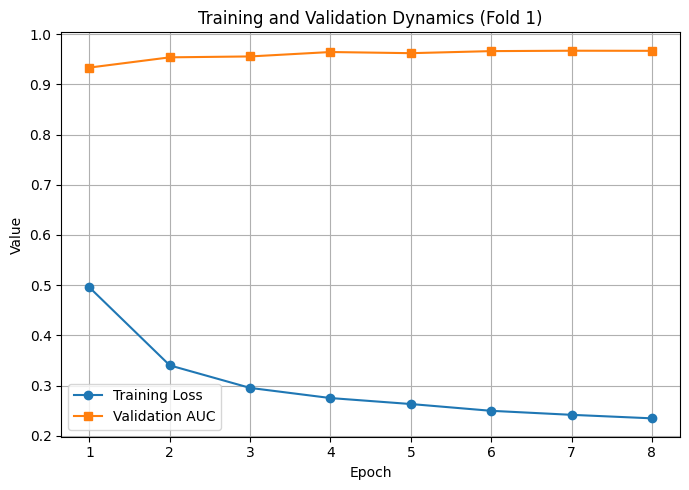

Saved: /content/drive/MyDrive/colab_outputs/training_dynamics_fold1.png


In [ ]:
# ===== Figure 1: Training dynamics (Fold 1) =====
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Epoch-wise values for Fold 1
# Used hard-coded values for plotting since re-running training would take time
train_losses = [0.4956, 0.3403, 0.2954, 0.2752, 0.2633, 0.2498, 0.2418, 0.2348]
val_aucs     = [0.9333, 0.9537, 0.9555, 0.9643, 0.9620, 0.9661, 0.9669, 0.9667]

epochs = np.arange(1, len(train_losses)+1)

plt.figure(figsize=(7,5))
plt.plot(epochs, train_losses, marker="o", label="Training Loss")
plt.plot(epochs, val_aucs, marker="s", label="Validation AUC")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training and Validation Dynamics (Fold 1)")
plt.grid(True)
plt.legend()
plt.tight_layout()

out_dir = Path("/content/drive/MyDrive/colab_outputs")
out_dir.mkdir(parents=True, exist_ok=True)
fig1_path = out_dir / "training_dynamics_fold1.png"
plt.savefig(fig1_path, dpi=150)
plt.show()
print("Saved:", fig1_path)


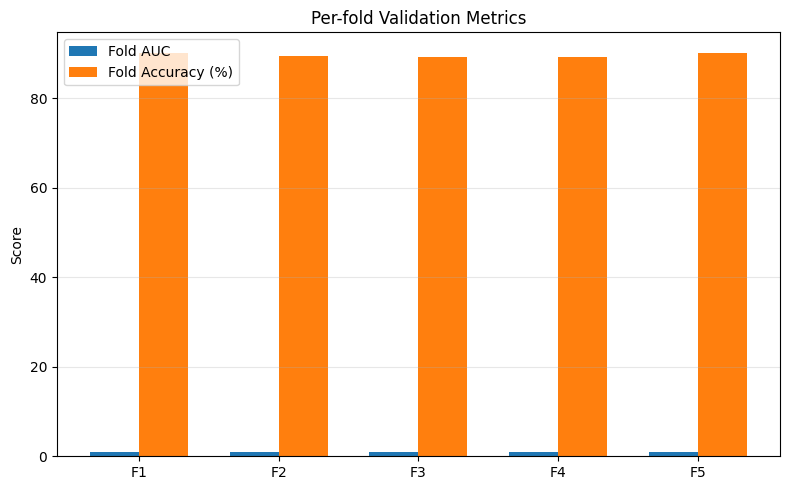

Saved: /content/drive/MyDrive/colab_outputs/per_fold_metrics.png
   Fold  Best AUC  Accuracy (%)
0     1    0.9669         90.08
1     2    0.9628         89.46
2     3    0.9625         89.31
3     4    0.9618         89.37
4     5    0.9654         90.26

OOF AUC: 0.9634 | OOF ACC (%): 89.67
Paragraph-level Validation — AUC: 0.92 | ACC (%): 80.0


In [ ]:
# ===== Figure 2: Per-fold AUC and Accuracy =====
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Used hard-coded values for plotting since re-running training would take time
fold_ids = [1, 2, 3, 4, 5]
fold_auc = [0.9669, 0.9628, 0.9625, 0.9618, 0.9654]
fold_acc = [90.08, 89.46, 89.31, 89.37, 90.26]  # as %

oof_auc = 0.9634
oof_acc = 89.67   # 0.8967 → percent
val_auc_para = 0.9200
val_acc_para = 80.00  # %

x = np.arange(len(fold_ids))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, fold_auc, width, label="Fold AUC")
plt.bar(x + width/2, fold_acc, width, label="Fold Accuracy (%)")
plt.xticks(x, [f"F{f}" for f in fold_ids])
plt.ylabel("Score")
plt.title("Per-fold Validation Metrics")
plt.grid(axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()

fig2_path = out_dir / "per_fold_metrics.png"
plt.savefig(fig2_path, dpi=150)
plt.show()
print("Saved:", fig2_path)

# Print summary table
df = pd.DataFrame({
    "Fold": fold_ids,
    "Best AUC": fold_auc,
    "Accuracy (%)": fold_acc
})
print(df)
print("\nOOF AUC:", oof_auc, "| OOF ACC (%):", oof_acc)
print("Paragraph-level Validation — AUC:", val_auc_para, "| ACC (%):", val_acc_para)


In [ ]:
# Build a one-file ensemble module that matches 5-fold
import torch
import torch.nn as nn

class EnsembleTokenTransformer(nn.Module):
    def __init__(self, num_models=5):
        super().__init__()
        self.models = nn.ModuleList([
            TokenTransformer(
                in_dim=768, model_dim=MODEL_DIM,
                n_heads=HEADS, ff_dim=FF,
                n_layers=LAYERS, dropout=DROPOUT
            ) for _ in range(num_models)
        ])

    def forward(self, x, mask):
        # average logits from all submodels (identical to ensemble logic)
        logits = []
        for m in self.models:
            logits.append(m(x, mask))
        # stack -> mean over models
        return torch.stack(logits, dim=0).mean(dim=0)

# load each fold into its slot, then save ONE .pt
fold_paths = [OUT_DIR / f"transformer_fold{i}.pt" for i in range(1, 6)]
assert all(p.exists() for p in fold_paths), "Missing some fold .pt files"

ens = EnsembleTokenTransformer(num_models=5)
for i, p in enumerate(fold_paths):
    sd = torch.load(p, map_location="cpu")
    ens.models[i].load_state_dict(sd)

final_ens_path = OUT_DIR / "final_ensemble.pt"
torch.save(ens.state_dict(), final_ens_path)
print("Saved exact-ensemble checkpoint ->", final_ens_path)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Saved exact-ensemble checkpoint -> /content/drive/MyDrive/colab_outputs/final_ensemble.pt


In [ ]:
# Load the single-file ensemble and create submission
import numpy as np
import pandas as pd
import torch

# rebuild the same wrapper class and load weights
ens_loaded = EnsembleTokenTransformer(num_models=5).to(device).eval()
ens_loaded.load_state_dict(torch.load(OUT_DIR / "final_ensemble.pt", map_location=device))
print("Loaded:", OUT_DIR / "final_ensemble.pt")

# sentence-level predictions (same as averaging the 5 folds)
test_logits = predict_logits(ens_loaded, test_loader_sent)
test_probs  = 1 / (1 + np.exp(-test_logits))

# paragraph aggregation (use the SAME rule you used for the ensemble file)
test_sent_df = pd.DataFrame({"id":[pid for _,_,pid in test_loader_sent.dataset], "prob":test_probs})
sub = test_sent_df.groupby("id")["prob"].mean().reset_index().rename(columns={"prob":"y_prob"})
sub.to_csv(OUT_DIR / "submission_from_final_ensemble.csv", index=False)
print("Saved submission (matches 5-fold) ->", OUT_DIR / "submission_from_final_ensemble.csv")

print(sub.head(), sub.shape)
assert sub.columns.tolist() == ["id","y_prob"]
assert sub["y_prob"].between(0,1).all()


Loaded: /content/drive/MyDrive/colab_outputs/final_ensemble.pt
Saved submission (matches 5-fold) -> /content/drive/MyDrive/colab_outputs/submission_from_final_ensemble.csv
   id    y_prob
0  15  0.070112
1  16  0.162575
2  17  0.055704
3  18  0.440571
4  19  0.189499 (180, 2)


## Model Performance Evaluation

To understand how well the Transformer model performed, we evaluated it across
out-of-fold (OOF) predictions and validation data.  
The following figures illustrate different aspects of performance:

- **ROC Curve** – how well the model separates AI vs. Human text across thresholds.  
- **Precision–Recall Curve** – balance between precision and recall, useful for imbalanced decisions.  
- **Probability Distributions** – how confident the model is for each class.  
- **Calibration Plot** – whether predicted probabilities align with true outcomes.  
- **Confusion Matrices** – actual vs. predicted labels at default and best-F1 thresholds.  
- **Per-Fold AUCs** – consistency of performance across cross-validation folds.  
- **Validation Paragraph-Level Results** – averaged sentence predictions at document level.  

Together, these plots provide a complete view of accuracy, reliability, and generalization.


Train tensors: (16322, 100, 768) Pos: 8161 Neg: 8161
Eval fold 1 ...


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Eval fold 2 ...


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Eval fold 3 ...


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Eval fold 4 ...


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Eval fold 5 ...


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


OOF AUC = 0.9634  |  per-fold AUCs = ['0.9667', '0.9627', '0.9625', '0.9618', '0.9654']


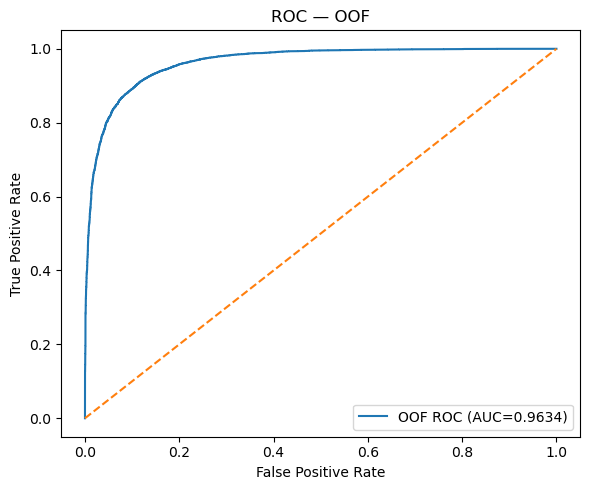

saved model/figures/01_oof_roc.png


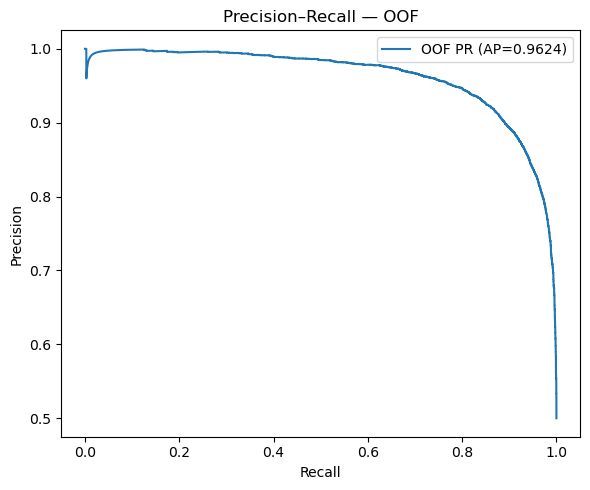

saved model/figures/02_oof_pr.png


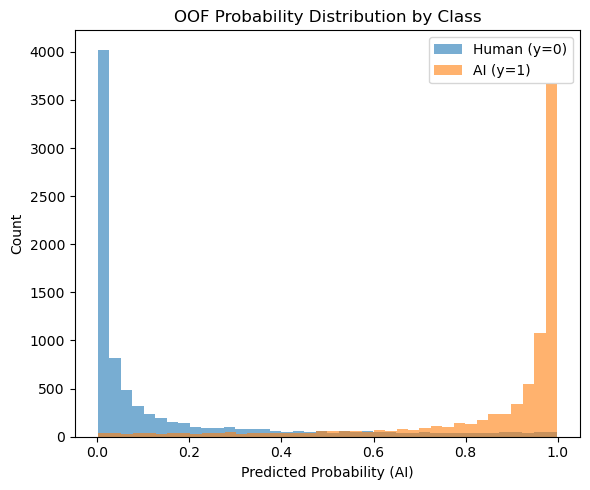

saved model/figures/03_oof_prob_hist.png


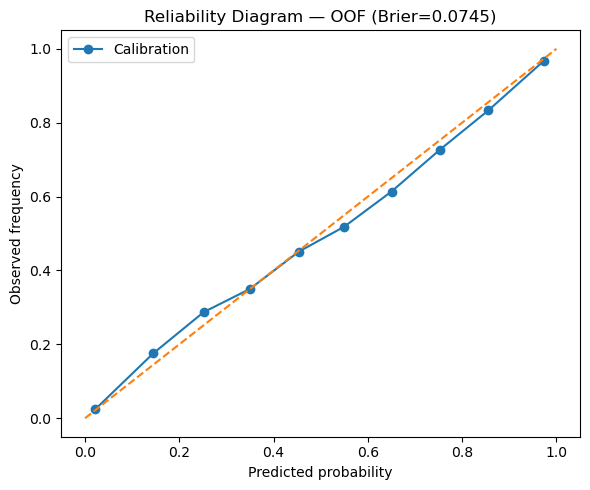

saved model/figures/04_oof_calibration.png


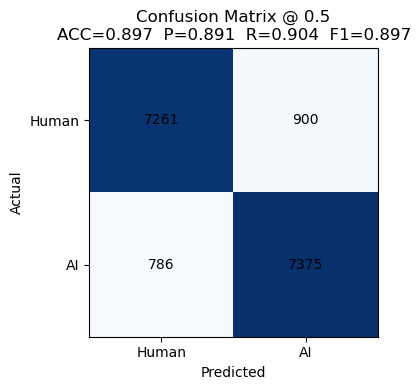

saved model/figures/05_cm_thr_0p50.png


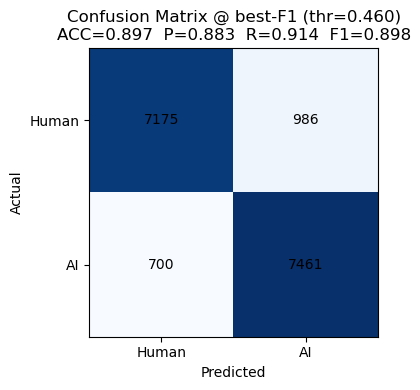

saved model/figures/06_cm_best_f1.png


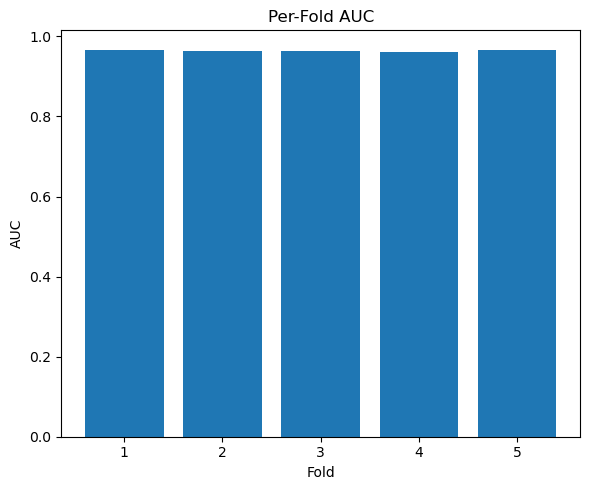

saved model/figures/07_fold_auc_bar.png


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


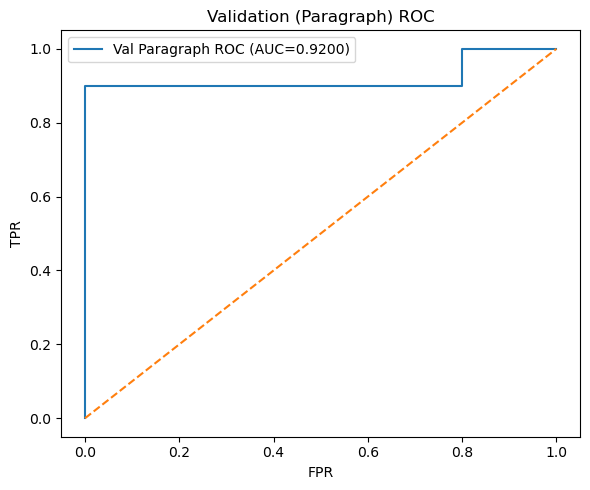

saved model/figures/08_val_paragraph_roc.png


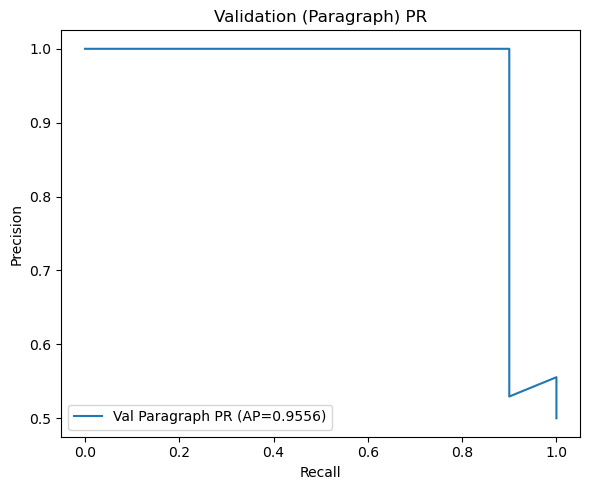

saved model/figures/09_val_paragraph_pr.png

All figures saved under: /Users/achaladias/Documents/Uni/Trimester 2 2025/using machine learning tools/ass03/assignment-3-language-detection/Aeman Fatima - a1946845/model/figures


In [ ]:
import os, json, math, gc
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve,
    average_precision_score, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score
)
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

# -------------------------
# Paths
# -------------------------
ROOT = Path(".")
DATA = ROOT / "data"
TRAIN_AI = DATA / "train" / "train_ai.npy"
TRAIN_HU = DATA / "train" / "train_human.npy"

VAL_JSONL = None
# try common locations
for p in [
    DATA / "train" / "validation.jsonl",
    DATA / "val" / "validation.jsonl",
    DATA / "validation.jsonl"
]:
    if p.exists():
        VAL_JSONL = p
        break

MODEL_DIR = ROOT / "model"
OUT_DIR = MODEL_DIR / "figures"
OUT_DIR.mkdir(parents=True, exist_ok=True)

assert TRAIN_AI.exists() and TRAIN_HU.exists(), "Missing train .npy files under data/train/"
assert MODEL_DIR.exists(), "Missing model directory with transformer_fold*.pt files"
if VAL_JSONL is None:
    print("WARNING: validation.jsonl not found. Paragraph-level plots will be skipped.")

# -------------------------
# Device
# -------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_float32_matmul_precision("high")

# -------------------------
# Utils: data loading
# -------------------------
def compute_token_mask(x_2d: np.ndarray) -> np.ndarray:
    # x_2d: (T=100, D=768); mask 1 where not all-zero
    return (np.abs(x_2d).sum(axis=1) > 0).astype(np.float32)

def load_train_arrays(ai_path, hu_path):
    ai = np.load(ai_path, allow_pickle=True).astype(np.float32)  # (Na,100,768)
    hu = np.load(hu_path, allow_pickle=True).astype(np.float32)  # (Nh,100,768)
    X = np.concatenate([ai, hu], axis=0)
    y = np.concatenate([np.ones(len(ai), dtype=np.int64),
                        np.zeros(len(hu), dtype=np.int64)], axis=0)
    return X, y

def read_grouped_jsonl(path, expect_label=True):
    """Reads paragraph JSONL: each line -> {"id":..., "features":[(100,768),...], "label":0/1?}
       Returns ids (list[str]), mats (list[np.ndarray Sx100x768]), labels (np.ndarray) if expected.
       Robust to nested lists; pads/truncates to 100 tokens if needed.
    """
    ids, mats, labels = [], [], []
    with open(path, "r") as f:
        for li, line in enumerate(f):
            obj = json.loads(line)
            ids.append(obj.get("id", str(li)))
            feats = obj["features"]
            bag = []
            # feats may be list of arrays OR a 3D array
            arr = np.array(feats, dtype=np.float32)
            if arr.ndim == 3 and arr.shape[1:] == (100, 768):
                mats.append(arr)
            else:
                for emb in feats:
                    e = np.array(emb, dtype=np.float32)
                    if e.ndim != 2 or e.shape[1] != 768:
                        raise ValueError(f"Bad embedding shape in line {li}: {e.shape}")
                    # pad/trunc to 100 tokens
                    T = e.shape[0]
                    if T >= 100:
                        e = e[:100]
                    else:
                        pad = np.zeros((100, 768), dtype=np.float32)
                        pad[:T] = e
                        e = pad
                    bag.append(e)
                mats.append(np.stack(bag))
            if expect_label:
                labels.append(int(obj["label"]))
    if expect_label:
        return ids, mats, np.array(labels, dtype=np.int64)
    return ids, mats

class SentenceDataset(Dataset):
    """For train/eval on flat sentences (X: Nx100x768, y: N)"""
    def __init__(self, X, y, aug=False):
        self.X = X; self.y = y; self.aug = aug
    def __len__(self): return len(self.X)
    def __getitem__(self, idx):
        x = self.X[idx]
        m = compute_token_mask(x)
        y = self.y[idx]
        return torch.from_numpy(x), torch.tensor(y, dtype=torch.long), torch.from_numpy(m)

class SentenceEvalDataset(Dataset):
    """Flattens paragraph -> sentences for eval; keeps mapping to paragraph id."""
    def __init__(self, mats, para_ids):
        self.samples = []
        for pid, para in zip(para_ids, mats):
            for s in range(len(para)):
                self.samples.append((para[s], pid))
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        x, pid = self.samples[idx]
        m = compute_token_mask(x)
        return torch.from_numpy(x), torch.from_numpy(m), pid

# -------------------------
# Model (matches training)
# -------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1, max_len, d_model)
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class TokenTransformer(nn.Module):
    def __init__(self, in_dim=768, model_dim=256, n_heads=8, ff_dim=512, n_layers=2, dropout=0.15):
        super().__init__()
        self.proj = nn.Linear(in_dim, model_dim)
        self.posenc = PositionalEncoding(model_dim, max_len=100)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=model_dim, nhead=n_heads, dim_feedforward=ff_dim,
            dropout=dropout, batch_first=True, activation="gelu", norm_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.pool_attn = nn.Sequential(nn.Linear(model_dim, model_dim), nn.Tanh(), nn.Linear(model_dim, 1))
        self.head = nn.Sequential(nn.LayerNorm(model_dim * 2), nn.Dropout(dropout), nn.Linear(model_dim * 2, 1))
    def forward(self, x, mask):
        # x: (B,T,768), mask: (B,T) with 1=valid
        x = self.proj(x)
        x = self.posenc(x)
        pad_mask = ~mask.bool()
        h = self.encoder(x, src_key_padding_mask=pad_mask)
        m = mask.unsqueeze(-1)
        h_masked = h * m
        denom = m.sum(dim=1).clamp(min=1.0)
        mean_pool = h_masked.sum(dim=1) / denom
        NEG_LARGE = -1e4
        max_pool = h.masked_fill(pad_mask.unsqueeze(-1), NEG_LARGE).max(dim=1).values
        attn_logits = self.pool_attn(h).masked_fill(pad_mask.unsqueeze(-1), NEG_LARGE)
        attn = torch.softmax(attn_logits, dim=1)
        attn_pool = (attn * h).sum(dim=1)
        fused = torch.cat([0.5 * (mean_pool + max_pool), attn_pool], dim=-1)
        return self.head(fused).squeeze(-1)

@torch.inference_mode()
def predict_logits(model, loader):
    model.eval()
    out = []
    for batch in loader:
        if len(batch) == 3:
            a, b, c = batch
            if hasattr(b, "ndim") and b.ndim == 2: xb, mb = a, b
            elif hasattr(c, "ndim") and c.ndim == 2: xb, mb = a, c
            else: raise ValueError("Cannot locate mask in 3-tuple batch.")
        else:
            xb, mb = batch
        xb = xb.to(device, non_blocking=True)
        mb = mb.to(device, non_blocking=True)
        with torch.amp.autocast(device_type='cuda', enabled=(device=='cuda')):
            logits = model(xb, mb)
        out.append(logits.detach().float().cpu())
    return torch.cat(out, dim=0).numpy()

def sigmoid(z): return 1 / (1 + np.exp(-z))

# -------------------------
# Load data & run OOF eval
# -------------------------
X_raw, y = load_train_arrays(TRAIN_AI, TRAIN_HU)
print("Train tensors:", X_raw.shape, "Pos:", y.sum(), "Neg:", (y==0).sum())

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_logits = np.zeros(len(X_raw), dtype=np.float32)
fold_aucs = []

BATCH_EVAL = 128
model_hparams = dict(in_dim=768, model_dim=256, n_heads=8, ff_dim=512, n_layers=2, dropout=0.15)

fold_ckpts = [MODEL_DIR / f"transformer_fold{i}.pt" for i in range(1, 6)]
assert all(p.exists() for p in fold_ckpts), "Expected transformer_fold1..5.pt in model/"

for fold, (tr_idx, va_idx) in enumerate(skf.split(X_raw, y), 1):
    print(f"Eval fold {fold} ...")
    valid_ds = SentenceDataset(X_raw[va_idx], y[va_idx], aug=False)
    valid_loader = DataLoader(valid_ds, batch_size=BATCH_EVAL, shuffle=False, num_workers=0, pin_memory=(device=='cuda'))
    model = TokenTransformer(**model_hparams).to(device)
    sd = torch.load(fold_ckpts[fold-1], map_location=device)
    model.load_state_dict(sd, strict=True)
    v_logits = predict_logits(model, valid_loader)
    oof_logits[va_idx] = v_logits
    v_auc = roc_auc_score(y[va_idx], sigmoid(v_logits))
    fold_aucs.append(v_auc)
    del model; gc.collect(); torch.cuda.empty_cache() if device=='cuda' else None

oof_probs = sigmoid(oof_logits)
oof_auc = roc_auc_score(y, oof_probs)
print(f"OOF AUC = {oof_auc:.4f}  |  per-fold AUCs = {[f'{a:.4f}' for a in fold_aucs]}")

# -------------------------
# Helper: save plots
# -------------------------
def savefig(name, fig=None):
    """
    Save figure to model/figures and also display inline in the notebook.
    Usage: call after you've finished plotting (no other changes needed).
    """
    if fig is None:
        fig = plt.gcf()

    path = OUT_DIR / name
    fig.tight_layout()
    fig.savefig(path, dpi=160, bbox_inches="tight")

    # show in notebook
    display(fig)

    # close to avoid memory/leakage in long runs
    plt.close(fig)
    print("saved", path)

# 1) ROC
fpr, tpr, _ = roc_curve(y, oof_probs)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"OOF ROC (AUC={oof_auc:.4f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC — OOF")
plt.legend()
savefig("01_oof_roc.png")

# 2) PR
prec, rec, _ = precision_recall_curve(y, oof_probs)
ap = average_precision_score(y, oof_probs)
plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"OOF PR (AP={ap:.4f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall — OOF")
plt.legend()
savefig("02_oof_pr.png")

# 3) Probability histograms by class
plt.figure(figsize=(6,5))
plt.hist(oof_probs[y==0], bins=40, alpha=0.6, label="Human (y=0)")
plt.hist(oof_probs[y==1], bins=40, alpha=0.6, label="AI (y=1)")
plt.xlabel("Predicted Probability (AI)"); plt.ylabel("Count")
plt.title("OOF Probability Distribution by Class")
plt.legend()
savefig("03_oof_prob_hist.png")

# 4) Calibration / reliability
prob_true, prob_pred = calibration_curve(y, oof_probs, n_bins=10, strategy="uniform")
brier = brier_score_loss(y, oof_probs)
plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker="o", label="Calibration")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("Predicted probability"); plt.ylabel("Observed frequency")
plt.title(f"Reliability Diagram — OOF (Brier={brier:.4f})")
plt.legend()
savefig("04_oof_calibration.png")

# 5) Confusion matrices @0.5 and @best-F1
def plot_cm(y_true, y_prob, thr, title, filename):
    y_hat = (y_prob >= thr).astype(int)
    cm = confusion_matrix(y_true, y_hat)
    acc = accuracy_score(y_true, y_hat)
    prec = precision_score(y_true, y_hat)
    rec_ = recall_score(y_true, y_hat)
    f1 = f1_score(y_true, y_hat)
    plt.figure(figsize=(5,4))
    plt.imshow(cm, cmap="Blues")
    for (i,j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.xticks([0,1], ["Human", "AI"]); plt.yticks([0,1], ["Human", "AI"])
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.title(f"{title}\nACC={acc:.3f}  P={prec:.3f}  R={rec_:.3f}  F1={f1:.3f}")
    savefig(filename)

# best F1 threshold
ths = np.linspace(0.01, 0.99, 199)
f1s = [f1_score(y, (oof_probs>=t).astype(int)) for t in ths]
best_thr = ths[int(np.argmax(f1s))]
plot_cm(y, oof_probs, 0.5, "Confusion Matrix @ 0.5", "05_cm_thr_0p50.png")
plot_cm(y, oof_probs, best_thr, f"Confusion Matrix @ best-F1 (thr={best_thr:.3f})", "06_cm_best_f1.png")

# 6) Fold-wise AUC bar chart
plt.figure(figsize=(6,5))
plt.bar(range(1,6), fold_aucs)
plt.xlabel("Fold"); plt.ylabel("AUC")
plt.title("Per-Fold AUC")
savefig("07_fold_auc_bar.png")

# -------------------------
# Validation paragraph-level (if file available)
# -------------------------
if VAL_JSONL is not None:
    val_ids, val_mats, val_labels = read_grouped_jsonl(VAL_JSONL, expect_label=True)
    val_sent_ds = SentenceEvalDataset(val_mats, val_ids)
    val_loader = DataLoader(val_sent_ds, batch_size=128, shuffle=False, num_workers=0, pin_memory=(device=='cuda'))

    # average sentence probs across folds then aggregate to paragraph means
    sent_prob_ens = np.zeros(len(val_sent_ds), dtype=np.float32)
    for i, ckpt in enumerate(fold_ckpts, 1):
        model = TokenTransformer(**model_hparams).to(device)
        sd = torch.load(ckpt, map_location=device)
        model.load_state_dict(sd, strict=True)
        logits = predict_logits(model, val_loader)
        sent_prob_ens += sigmoid(logits) / 5.0
        del model; gc.collect(); torch.cuda.empty_cache() if device=='cuda' else None

    # Map sentence → paragraph
    sent_ids = [pid for _,_,pid in val_sent_ds]
    df = pd.DataFrame({"id": sent_ids, "prob": sent_prob_ens})
    para = df.groupby("id")["prob"].mean().reindex(val_ids).to_numpy()
    labels = pd.Series(val_labels, index=val_ids).reindex(val_ids).to_numpy()

    v_auc = roc_auc_score(labels, para)
    v_ap  = average_precision_score(labels, para)
    fpr, tpr, _ = roc_curve(labels, para)
    prec, rec, _ = precision_recall_curve(labels, para)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"Val Paragraph ROC (AUC={v_auc:.4f})")
    plt.plot([0,1],[0,1],"--")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Validation (Paragraph) ROC")
    plt.legend(); savefig("08_val_paragraph_roc.png")

    plt.figure(figsize=(6,5))
    plt.plot(rec, prec, label=f"Val Paragraph PR (AP={v_ap:.4f})")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Validation (Paragraph) PR")
    plt.legend(); savefig("09_val_paragraph_pr.png")

print("\nAll figures saved under:", OUT_DIR.resolve())
